# LDA visualization: Topic label 0-19
## NOTE: Approach 2 for calculate Dominant topic => Result may be different from APPROACH 1

**APPROACH 1:** (Based on the user-defined-function by Lacic et al. - This one was used during feature engineering)
Method:
- Extracting words from the text.
- Checking which of these words are present in the feature_names of the LDA model.
- For each topic, calculate the sum of word importances (from the LDA components) only for the words that overlap with the document.
- Assign the topic with the maximum summed importance as the dominant topic for the document.


**APPROACH 2:** This is the more standard way of determining the dominant topic using scikit-learn's LDA.
Method: 
- Directly transforming the document-term matrix with the LDA model to get the topic distribution for each document. 
- Assign the topic with the highest probability as the dominant topic for the document.

APPROACH 1 is based on the raw occurrence of words from the document in the LDA components, whereas APPROACH 2 is based on the probabilistic topic distribution of the document as outputted by the LDA model.

In [1]:
import numpy as np
import pandas as pd
import subprocess
import argparse
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, LatentDirichletAllocation
from bs4 import BeautifulSoup
import pickle

In [2]:
# Run this for reproduce
# Gets the current working directory
import os
cwd = os.getcwd()
print("Working directory:", cwd)
# Go up one directory from working directory
os.chdir("..")

Working directory: /Users/anhtth/Library/CloudStorage/OneDrive-UniversityofTwente/2023 UT- THESIS/1-Code/0.cb12_main/nb_xai_viz


In [3]:
import warnings
warnings.filterwarnings("ignore")

In [4]:
interim_path = "./cb12-interim/"

# Load LDA model and feature names

In [5]:
# LDA model for jobs

lda_title = pickle.load(open(interim_path + "lda_title.model", 'rb'))
tf_feature_names_title = pickle.load(open(interim_path + "lda_title.fnames", 'rb'))

lda_desc = pickle.load(open(interim_path + "lda_desc.model", 'rb'))
tf_feature_names_desc = pickle.load(open(interim_path + "lda_desc.fnames", 'rb'))

lda_req = pickle.load(open(interim_path + "lda_req.model", 'rb'))
tf_feature_names_req = pickle.load(open(interim_path + "lda_req.fnames", 'rb'))

#display_topics(lda_title, tf_feature_names_title, 10)
#display_topics(lda_desc, tf_feature_names_desc, 10)
#display_topics(lda_req, tf_feature_names_req, 10)

In [6]:
# LDA model for work history
lda_user = pickle.load(open(interim_path + "lda_user_history.model", 'rb'))
tf_feature_names_user = pickle.load(open(interim_path + "lda_user_history.fnames", 'rb'))

# Load user defined function used in LDA

In [7]:
def display_topics(model, feature_names, no_top_words):
    for topic_idx, topic in enumerate(model.components_):
        print("Topic %d:" % (topic_idx))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]))
        
def calc_lda(df, no_features = 1000, no_topics = 20):
    # LDA can only use raw term counts for LDA because it is a probabilistic graphical model
    tf_vectorizer = CountVectorizer(max_df=0.95, 
                                    min_df=2, 
                                    max_features=no_features, 
                                    stop_words='english')
    tf = tf_vectorizer.fit_transform(df)
    tf_feature_names = tf_vectorizer.get_feature_names_out()

    # Run LDA
    lda = LatentDirichletAllocation(n_components=no_topics, 
                                    max_iter=5, 
                                    learning_method='online', 
                                    learning_offset=50.,random_state=0).fit(tf)


    no_top_words = 5
    display_topics(lda, tf_feature_names, no_top_words)
    return lda, tf_feature_names

In [8]:
def apply_topics(text, model, feature_names, fn_dict):
    words = re.findall(r"[\w']+", text)
        
    overlap = [value for value in feature_names if value in words]
    
    max_sum_t = -1.0
    max_topic_idx = None
    for topic_idx, topic in enumerate(model.components_):
        sum_t = 0.0
        for word in overlap:
            sum_t += topic[fn_dict[word]]
        
        if sum_t > max_sum_t:
            max_sum_t = sum_t
            max_topic_idx = topic_idx
    
    return max_topic_idx

        
def gen_fn_dict(feature_names):
    fn_dict = {}
    f_idx = 0
    
    for name in feature_names:
        fn_dict[name] = f_idx
        f_idx += 1
        
    return fn_dict

fn_dict_req = gen_fn_dict(tf_feature_names_req)
fn_dict_desc = gen_fn_dict(tf_feature_names_desc)
fn_dict_title = gen_fn_dict(tf_feature_names_title)


# Import data

In [9]:
# Raw jobs data with text
jobs = pd.read_csv("./data_processed/jobset_clean.csv")

In [10]:
# jobset after LDA (with 3 columns of topic model)
job_lda = pd.read_csv(interim_path + "jobset_lda.csv")

In [11]:
# jobset only contain LDA topic model
job_fm = pd.read_csv('./data_interim/jobs_fm.csv')

In [12]:
jobs["Requirements"].fillna("", inplace=True)
jobs["Description"].fillna("", inplace=True)
jobs["Title"].fillna("", inplace=True)

In [13]:
len(jobs) == len(job_lda)

True

In [14]:
len(job_lda) == len(job_fm)

True

## User work history corpus

In [15]:
# user set after LDA (corpus: column: JobTitle, dominant topic: column: WorkHistoryTopic)
user_lda = pd.read_csv(interim_path + "user_history_lda.csv")

In [16]:
# user only contain LDA topic model and discretized feature of user profile
user_fm = pd.read_csv('./data_interim/users_fm.csv')

In [17]:
len(user_lda) == len(user_fm)

True

# Load the tf_vectorizer used before training LDA model

In [18]:
np.random.seed(0) 
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                min_df=2, 
                                max_features=1000, 
                                stop_words='english')


# Topic contribution for each document

In [19]:
# Styling
def color_green(val):
    color = 'green' if val > .1 else 'black'
    return 'color: {col}'.format(col=color)
def make_bold(val):
    weight = 700 if val > .1 else 400
    return 'font-weight: {weight}'.format(weight=weight)

## Corpus: Job Requirement

In [20]:
np.random.seed(0) 
tf_req = tf_vectorizer.fit_transform(jobs["Requirements"])

In [21]:
corpus_req = tf_req.toarray()

In [22]:
np.random.seed(0) 
# Create Document — Topic Matrix
lda_output = lda_req.transform(tf_req)

In [23]:
# function to get documents index for job corpus, given JobID
def get_doc_idx(j_id):
    job = job_lda[job_lda.JobID==j_id]
    j_idx = job.index.values[0]
    return j_idx

In [24]:
# function to get documents index for work history corpus, given UserID
def get_user_idx(u_id):
    user = user_lda[user_lda.UserID==u_id]
    u_idx = user.index.values[0]
    return u_idx

### Calculate Dominant Topic: Use case

In [25]:
## Test one one Job ID, using apply_topics function:
user_id = 13
job_id = 32115

In [26]:
job_doc_idx = get_doc_idx(j_id=job_id)
job_doc_idx

823340

In [27]:
job_lda[job_lda.JobID==job_id].T

823340
JobID                                                     32115
WindowID                                                      6
Title                Specialized  Transportation  Services, Inc
Description   Specialized       Transportation       Service...
Requirements  Please refer to the Job Description to view th...
City                                                     Smyrna
State                                                        TN
Country                                                      US
Zip5                                                    37167.0
StartDate                               2012-05-12 00:10:16.827
EndDate                                     2012-06-11 23:59:59
ReqTopic                                                     15
DescTopic                                                    13
TitTopic                                                      0

In [28]:
jobs['Requirements'][job_doc_idx]

'Please refer to the Job Description to view the requirements for this job'

In [29]:
# Check with the apply_topics function for the document
import re
apply_topics(text = jobs['Requirements'][job_doc_idx],
             model = lda_req,
             feature_names = tf_feature_names_req,
             fn_dict = fn_dict_req)

15

In [30]:
# Check with the apply_topics function for the document
import re
apply_topics(text = jobs['Description'][job_doc_idx],
             model = lda_desc,
             feature_names = tf_feature_names_desc,
             fn_dict = fn_dict_desc)

13

In [31]:
# Check with the apply_topics function for the document
import re
apply_topics(text = jobs['Title'][job_doc_idx],
             model = lda_title,
             feature_names = tf_feature_names_title,
             fn_dict = fn_dict_title)

0

In [32]:
user_doc_idx = get_user_idx(u_id=user_id)
user_doc_idx

112440

In [33]:
fn_dict_user = gen_fn_dict(tf_feature_names_user)

In [34]:
# Check with the apply_topics function for the document
import re
apply_topics(text = user_lda['JobTitle'][user_doc_idx],
             model = lda_user,
             feature_names = tf_feature_names_user,
             fn_dict = fn_dict_user)

0

In [35]:
user_lda[user_lda.UserID == user_id].T

112440
UserID                                                               13
Split                                                              Test
City                                                       Philadelphia
State                                                                PA
Country                                                              US
DegreeType                                                            4
WorkHistoryCount                                                      6
TotalYearsExperience                                                5.0
CurrentlyEmployed                                                     1
ManagedOthers                                                         0
ManagedHowMany                                                        0
JobTitle              Pennsylvania MentorStudent WorkerInternship in...
WorkHistoryTopic                                                      0

### Calculate dominant topic and topic contribution

In [36]:
jobs.index.values

array([      0,       1,       2, ..., 1050506, 1050507, 1050508])

In [37]:
# column names
topicnames = ['Topic' + str(i) for i in range(lda_req.n_components)]
# index names
docnames = ['JobReq' + str(i) for i in jobs.index.values]

In [38]:
# Make the pandas dataframe
df_document_topic = pd.DataFrame(np.round(lda_output, 2), columns=topicnames, index=docnames)

In [39]:
df_document_topic.head()

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
JobReq0    0.00    0.00    0.00    0.00    0.03    0.46    0.00    0.00   
JobReq1    0.00    0.00    0.05    0.08    0.00    0.00    0.00    0.00   
JobReq2    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   
JobReq3    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   
JobReq4    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   

         Topic8  Topic9  Topic10  Topic11  Topic12  Topic13  Topic14  Topic15  \
JobReq0    0.43    0.00     0.00     0.07     0.00     0.00     0.00     0.00   
JobReq1    0.35    0.00     0.00     0.00     0.00     0.00     0.00     0.00   
JobReq2    0.01    0.01     0.01     0.01     0.01     0.01     0.01     0.01   
JobReq3    0.01    0.01     0.01     0.01     0.01     0.01     0.01     0.01   
JobReq4    0.01    0.01     0.01     0.01     0.01     0.01     0.01     0.01   

         Topic16  Topic17  Topic18  Topic19  
JobReq0     0.00     0.00     0.00     0.00  
JobReq1     0.00     0.00     0.50     0.00  
JobReq2     0.01     0.01     0.01     0.01  
JobReq3     0.01     0.01     0.01     0.01  
JobReq4     0.01     0.01     0.01     0.01

In [40]:
# Get dominant topic for each document
dominant_topic = np.argmax(df_document_topic.values, axis=1)
df_document_topic['dominant_topic'] = dominant_topic

In [41]:
df_document_topic.head()

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
JobReq0    0.00    0.00    0.00    0.00    0.03    0.46    0.00    0.00   
JobReq1    0.00    0.00    0.05    0.08    0.00    0.00    0.00    0.00   
JobReq2    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   
JobReq3    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   
JobReq4    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   

         Topic8  Topic9  ...  Topic11  Topic12  Topic13  Topic14  Topic15  \
JobReq0    0.43    0.00  ...     0.07     0.00     0.00     0.00     0.00   
JobReq1    0.35    0.00  ...     0.00     0.00     0.00     0.00     0.00   
JobReq2    0.01    0.01  ...     0.01     0.01     0.01     0.01     0.01   
JobReq3    0.01    0.01  ...     0.01     0.01     0.01     0.01     0.01   
JobReq4    0.01    0.01  ...     0.01     0.01     0.01     0.01     0.01   

         Topic16  Topic17  Topic18  Topic19  dominant_topic  
JobReq0     0.00     0.00     0.00     0.00               5  
JobReq1     0.00     0.00     0.50     0.00              18  
JobReq2     0.01     0.01     0.01     0.01               6  
JobReq3     0.01     0.01     0.01     0.01               6  
JobReq4     0.01     0.01     0.01     0.01               6  

[5 rows x 21 columns]

In [42]:
df_document_topic['JobID'] = jobs.JobID.values

In [43]:
# Job requirement topic contribution (whole corpus)
df_document_topic.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050509 entries, JobReq0 to JobReq1050508
Data columns (total 22 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Topic0          1050509 non-null  float64
 1   Topic1          1050509 non-null  float64
 2   Topic2          1050509 non-null  float64
 3   Topic3          1050509 non-null  float64
 4   Topic4          1050509 non-null  float64
 5   Topic5          1050509 non-null  float64
 6   Topic6          1050509 non-null  float64
 7   Topic7          1050509 non-null  float64
 8   Topic8          1050509 non-null  float64
 9   Topic9          1050509 non-null  float64
 10  Topic10         1050509 non-null  float64
 11  Topic11         1050509 non-null  float64
 12  Topic12         1050509 non-null  float64
 13  Topic13         1050509 non-null  float64
 14  Topic14         1050509 non-null  float64
 15  Topic15         1050509 non-null  float64
 16  Topic16         1050509 non-n

In [44]:
df_document_topic.head()

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
JobReq0    0.00    0.00    0.00    0.00    0.03    0.46    0.00    0.00   
JobReq1    0.00    0.00    0.05    0.08    0.00    0.00    0.00    0.00   
JobReq2    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   
JobReq3    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   
JobReq4    0.01    0.01    0.01    0.01    0.01    0.01    0.86    0.01   

         Topic8  Topic9  ...  Topic12  Topic13  Topic14  Topic15  Topic16  \
JobReq0    0.43    0.00  ...     0.00     0.00     0.00     0.00     0.00   
JobReq1    0.35    0.00  ...     0.00     0.00     0.00     0.00     0.00   
JobReq2    0.01    0.01  ...     0.01     0.01     0.01     0.01     0.01   
JobReq3    0.01    0.01  ...     0.01     0.01     0.01     0.01     0.01   
JobReq4    0.01    0.01  ...     0.01     0.01     0.01     0.01     0.01   

         Topic17  Topic18  Topic19  dominant_topic  JobID  
JobReq0     0.00     0.00     0.00               5      1  
JobReq1     0.00     0.50     0.00              18      4  
JobReq2     0.01     0.01     0.01               6      7  
JobReq3     0.01     0.01     0.01               6      8  
JobReq4     0.01     0.01     0.01               6      9  

[5 rows x 22 columns]

In [45]:
# Validate usecase (JobID = 32115) => 15
df_document_topic[df_document_topic.JobID==job_id].T

JobReq823340
Topic0                  0.01
Topic1                  0.01
Topic2                  0.01
Topic3                  0.01
Topic4                  0.01
Topic5                  0.01
Topic6                  0.86
Topic7                  0.01
Topic8                  0.01
Topic9                  0.01
Topic10                 0.01
Topic11                 0.01
Topic12                 0.01
Topic13                 0.01
Topic14                 0.01
Topic15                 0.01
Topic16                 0.01
Topic17                 0.01
Topic18                 0.01
Topic19                 0.01
dominant_topic          6.00
JobID               32115.00

In [46]:
df_document_topic.to_csv('./nb_xai_viz/job_req_topic_contribution_approach2.csv', header=True, index=False)

## Corpus: Job Description

In [47]:
np.random.seed(0)
tf_desc = tf_vectorizer.fit_transform(jobs["Description"])

In [48]:
corpus_desc = tf_desc.toarray()

In [49]:
np.random.seed(0)

# Create Document — Topic Matrix
lda_output_desc = lda_desc.transform(tf_desc)

# column names
topicnames_desc = ['Topic' + str(i) for i in range(lda_desc.n_components)]

# index names
# docnames_desc = ['JobDesc' + str(i) for i in range(len(jobs))] # OLD
docnames_desc = ['JobDesc' + str(i) for i in jobs.index.values]

# Make the pandas dataframe
df_document_topic_desc = pd.DataFrame(np.round(lda_output_desc, 2), columns=topicnames_desc, index=docnames_desc)

# Get dominant topic for each document
dominant_topic_desc = np.argmax(df_document_topic_desc.values, axis=1)
df_document_topic_desc['dominant_topic'] = dominant_topic_desc

In [50]:
df_document_topic_desc.head()

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
JobDesc0    0.00    0.18    0.00     0.0    0.00     0.0    0.00    0.00   
JobDesc1    0.07    0.00    0.00     0.0    0.05     0.1    0.03    0.00   
JobDesc2    0.00    0.00    0.14     0.0    0.00     0.0    0.00    0.00   
JobDesc3    0.00    0.00    0.00     0.0    0.10     0.0    0.00    0.38   
JobDesc4    0.00    0.00    0.00     0.0    0.00     0.0    0.00    0.41   

          Topic8  Topic9  ...  Topic11  Topic12  Topic13  Topic14  Topic15  \
JobDesc0    0.19    0.22  ...     0.00      0.0     0.16      0.0     0.20   
JobDesc1    0.00    0.27  ...     0.00      0.0     0.00      0.0     0.35   
JobDesc2    0.00    0.00  ...     0.00      0.0     0.43      0.0     0.00   
JobDesc3    0.00    0.00  ...     0.04      0.0     0.46      0.0     0.00   
JobDesc4    0.00    0.00  ...     0.00      0.0     0.41      0.0     0.00   

          Topic16  Topic17  Topic18  Topic19  dominant_topic  
JobDesc0      0.0     0.05     0.00     0.00               9  
JobDesc1      0.0     0.09     0.03     0.00              15  
JobDesc2      0.0     0.00     0.26     0.12              13  
JobDesc3      0.0     0.00     0.00     0.00              13  
JobDesc4      0.0     0.00     0.00     0.00               7  

[5 rows x 21 columns]

In [51]:
df_document_topic_desc['JobID'] = jobs.JobID.values

In [52]:
df_document_topic_desc.head()

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
JobDesc0    0.00    0.18    0.00     0.0    0.00     0.0    0.00    0.00   
JobDesc1    0.07    0.00    0.00     0.0    0.05     0.1    0.03    0.00   
JobDesc2    0.00    0.00    0.14     0.0    0.00     0.0    0.00    0.00   
JobDesc3    0.00    0.00    0.00     0.0    0.10     0.0    0.00    0.38   
JobDesc4    0.00    0.00    0.00     0.0    0.00     0.0    0.00    0.41   

          Topic8  Topic9  ...  Topic12  Topic13  Topic14  Topic15  Topic16  \
JobDesc0    0.19    0.22  ...      0.0     0.16      0.0     0.20      0.0   
JobDesc1    0.00    0.27  ...      0.0     0.00      0.0     0.35      0.0   
JobDesc2    0.00    0.00  ...      0.0     0.43      0.0     0.00      0.0   
JobDesc3    0.00    0.00  ...      0.0     0.46      0.0     0.00      0.0   
JobDesc4    0.00    0.00  ...      0.0     0.41      0.0     0.00      0.0   

          Topic17  Topic18  Topic19  dominant_topic  JobID  
JobDesc0     0.05     0.00     0.00               9      1  
JobDesc1     0.09     0.03     0.00              15      4  
JobDesc2     0.00     0.26     0.12              13      7  
JobDesc3     0.00     0.00     0.00              13      8  
JobDesc4     0.00     0.00     0.00               7      9  

[5 rows x 22 columns]

In [53]:
# Validate usecase (JobID = 32115) => 13
df_document_topic_desc[df_document_topic_desc.JobID==job_id].T

JobDesc823340
Topic0                   0.00
Topic1                   0.00
Topic2                   0.00
Topic3                   0.00
Topic4                   0.00
Topic5                   0.06
Topic6                   0.00
Topic7                   0.00
Topic8                   0.00
Topic9                   0.00
Topic10                  0.06
Topic11                  0.00
Topic12                  0.00
Topic13                  0.78
Topic14                  0.00
Topic15                  0.00
Topic16                  0.00
Topic17                  0.00
Topic18                  0.06
Topic19                  0.00
dominant_topic          13.00
JobID                32115.00

In [54]:
df_document_topic_desc.to_csv('./nb_xai_viz/job_desc_topic_contribution_approach2.csv', header=True, index=False)

## Corpus: Job Titles

In [55]:
np.random.seed(0)
tf_title = tf_vectorizer.fit_transform(jobs["Title"])
corpus_title = tf_title.toarray()

In [56]:
%%time
np.random.seed(0)

# Create Document — Topic Matrix
lda_output_title = lda_title.transform(tf_title)

# column names
topicnames_title = ['Topic' + str(i) for i in range(lda_title.n_components)]

# index names
# docnames_title = ['JobTitle' + str(i) for i in range(len(jobs))] # OLD
docnames_title = ['JobDesc' + str(i) for i in jobs.index.values]

# Make the pandas dataframe
df_document_topic_title = pd.DataFrame(np.round(lda_output_title, 2), columns=topicnames_title, index=docnames_title)

# Get dominant topic for each document
dominant_topic_title = np.argmax(df_document_topic_title.values, axis=1)
df_document_topic_title['dominant_topic'] = dominant_topic_title

CPU times: user 24.9 s, sys: 414 ms, total: 25.3 s
Wall time: 25.5 s


In [57]:
df_document_topic_title.head()

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
JobDesc0    0.01    0.01    0.01    0.01    0.01    0.01    0.21    0.41   
JobDesc1    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01   
JobDesc2    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01   
JobDesc3    0.26    0.01    0.01    0.01    0.01    0.01    0.01    0.01   
JobDesc4    0.03    0.03    0.03    0.03    0.03    0.03    0.03    0.03   

          Topic8  Topic9  ...  Topic11  Topic12  Topic13  Topic14  Topic15  \
JobDesc0    0.01    0.01  ...     0.01     0.01     0.01     0.21     0.01   
JobDesc1    0.01    0.01  ...     0.01     0.76     0.01     0.01     0.01   
JobDesc2    0.01    0.01  ...     0.01     0.01     0.01     0.01     0.01   
JobDesc3    0.01    0.01  ...     0.01     0.01     0.01     0.01     0.01   
JobDesc4    0.03    0.03  ...     0.03     0.03     0.52     0.03     0.03   

          Topic16  Topic17  Topic18  Topic19  dominant_topic  
JobDesc0     0.01     0.01     0.01     0.01               7  
JobDesc1     0.01     0.01     0.01     0.01              12  
JobDesc2     0.01     0.76     0.01     0.01              17  
JobDesc3     0.01     0.01     0.01     0.01              10  
JobDesc4     0.03     0.03     0.03     0.03              13  

[5 rows x 21 columns]

In [58]:
df_document_topic_title['JobID'] = jobs.JobID.values

In [59]:
df_document_topic_title.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1050509 entries, JobDesc0 to JobDesc1050508
Data columns (total 22 columns):
 #   Column          Non-Null Count    Dtype  
---  ------          --------------    -----  
 0   Topic0          1050509 non-null  float64
 1   Topic1          1050509 non-null  float64
 2   Topic2          1050509 non-null  float64
 3   Topic3          1050509 non-null  float64
 4   Topic4          1050509 non-null  float64
 5   Topic5          1050509 non-null  float64
 6   Topic6          1050509 non-null  float64
 7   Topic7          1050509 non-null  float64
 8   Topic8          1050509 non-null  float64
 9   Topic9          1050509 non-null  float64
 10  Topic10         1050509 non-null  float64
 11  Topic11         1050509 non-null  float64
 12  Topic12         1050509 non-null  float64
 13  Topic13         1050509 non-null  float64
 14  Topic14         1050509 non-null  float64
 15  Topic15         1050509 non-null  float64
 16  Topic16         1050509 non

In [60]:
# Validate usecase (JobID = 32155) => 0
df_document_topic_title[df_document_topic_title.JobID==job_id].T

JobDesc823340
Topic0                   0.02
Topic1                   0.02
Topic2                   0.02
Topic3                   0.02
Topic4                   0.02
Topic5                   0.35
Topic6                   0.02
Topic7                   0.02
Topic8                   0.02
Topic9                   0.02
Topic10                  0.02
Topic11                  0.35
Topic12                  0.02
Topic13                  0.02
Topic14                  0.02
Topic15                  0.02
Topic16                  0.02
Topic17                  0.02
Topic18                  0.02
Topic19                  0.02
dominant_topic           5.00
JobID                32115.00

In [61]:
df_document_topic_title.to_csv('./nb_xai_viz/job_title_topic_contribution_approach2.csv', header=True, index=False)

## Corpus: User Work history

In [62]:
user_lda.head()

UserID  Split          City State Country  DegreeType  WorkHistoryCount  \
0      80  Train  Williamstown    NJ      US           1                 5   
1     123  Train   Baton Rouge    LA      US           4                 1   
2     162  Train    Long Beach    CA      US           5                10   
3     178  Train    Greenville    SC      US           1                 6   
4     344  Train  Newport News    VA      US           1                 3   

   TotalYearsExperience  CurrentlyEmployed  ManagedOthers  ManagedHowMany  \
0                  11.0                  1              1               5   
1                   9.0                  1              0               0   
2                  25.0                  0              0               0   
3                  35.0                  0              1               4   
4                   7.0                  1              0               0   

                                            JobTitle  WorkHistoryTopic  
0  Auto Publishing/Electro Mechanical Technician,...                 9  
1                    Lead Hostess and Takeout Server                 0  
2  Student AssistantGraduate AssistantTreasurerOw...                 0  
3  CHEMICAL MANAGERChemical Management Company Sp...                 0  
4                           Restaurant ServerCashier                 0

In [63]:
np.random.seed(0)
tf_vectorizer = CountVectorizer(max_df=0.95, 
                                    min_df=2, 
                                    max_features=1000, 
                                    stop_words='english')
tf_user = tf_vectorizer.fit_transform(user_lda["JobTitle"])
corpus_user = tf_user.toarray()

In [64]:
%%time
np.random.seed(0)
# Create Document — Topic Matrix
lda_output_user = lda_user.transform(tf_user)

# column names
topicnames_user = ['Topic' + str(i) for i in range(lda_user.n_components)]

# index names
#docnames_user = ['WorkHistory' + str(i) for i in range(len(user_lda))]
docnames_user = ['WorkHistory' + str(i) for i in user_lda.index.values]

# Make the pandas dataframe
df_document_topic_user = pd.DataFrame(np.round(lda_output_user, 2), columns=topicnames_user, index=docnames_user)

# Get dominant topic for each document
dominant_topic_user = np.argmax(df_document_topic_user.values, axis=1)
df_document_topic_user['dominant_topic'] = dominant_topic_user

CPU times: user 5.27 s, sys: 79.5 ms, total: 5.35 s
Wall time: 5.4 s


In [65]:
calc_lda(user_lda["JobTitle"])

Topic 0:
cashier counselor property lab retail
Topic 1:
manager senior maintenance owner shift
Topic 2:
support operations technical rep member
Topic 3:
sales manager resources human representative
Topic 4:
business officer leader manager managersales
Topic 5:
manager marketing lead store managerassistant
Topic 6:
specialist administrator manager secretary resource
Topic 7:
development staff social work managerdirector
Topic 8:
operator production worker receiving forklift
Topic 9:
technician engineer management agent quality
Topic 10:
service customer representative inventory representativecustomer
Topic 11:
account analyst president time systems
Topic 12:
supervisor control warehouse field contract
Topic 13:
desk financial center program designer
Topic 14:
coordinator care nurse health case
Topic 15:
director project executive general consultant
Topic 16:
assistant office administrative medical billing
Topic 17:
associate data driver intern certified
Topic 18:
clerk services team ent

(LatentDirichletAllocation(learning_method='online', learning_offset=50.0,
                           max_iter=5, n_components=20, random_state=0),
 array(['2nd', '3rd', 'abuse', 'academic', 'access', 'account',
        'accountant', 'accountantaccountant', 'accountantaccounting',
        'accountantaccounts', 'accountantsenior', 'accountantstaff',
        'accounting', 'accounts', 'acquisition', 'acting', 'activities',
        'activity', 'adjunct', 'adjuster', 'admin', 'administration',
        'administrative', 'administrator', 'administratoradministrative',
        'administratornetwork', 'administratoroffice',
        'administratorsenior', 'admissions', 'adult', 'advanced',
        'advertising', 'advisor', 'advocate', 'affairs', 'agency', 'agent',
        'agentcustomer', 'agentsales', 'aid', 'aide', 'air', 'aircraft',
        'ambassador', 'america', 'american', 'amp', 'analysis', 'analyst',
        'analystassistant', 'analystbusiness', 'analystcustomer',
        'analystfinan

In [66]:
df_document_topic_user.head()

Topic0  Topic1  Topic2  Topic3  Topic4  Topic5  Topic6  Topic7  \
WorkHistory0    0.00    0.00    0.00    0.00    0.00    0.00    0.00    0.00   
WorkHistory1    0.01    0.01    0.01    0.01    0.01    0.26    0.01    0.01   
WorkHistory2    0.01    0.01    0.01    0.01    0.01    0.01    0.51    0.01   
WorkHistory3    0.01    0.01    0.01    0.01    0.01    0.01    0.01    0.01   
WorkHistory4    0.03    0.03    0.03    0.03    0.03    0.03    0.03    0.03   

              Topic8  Topic9  ...  Topic11  Topic12  Topic13  Topic14  \
WorkHistory0    0.00    0.84  ...     0.00     0.00     0.00     0.00   
WorkHistory1    0.01    0.01  ...     0.01     0.26     0.01     0.01   
WorkHistory2    0.01    0.01  ...     0.01     0.01     0.01     0.01   
WorkHistory3    0.01    0.72  ...     0.01     0.01     0.01     0.01   
WorkHistory4    0.03    0.03  ...     0.03     0.03     0.52     0.03   

              Topic15  Topic16  Topic17  Topic18  Topic19  dominant_topic  
WorkHistory0     0.00     0.00     0.09     0.00     0.00               9  
WorkHistory1     0.26     0.01     0.01     0.01     0.01               5  
WorkHistory2     0.01     0.01     0.01     0.01     0.26               6  
WorkHistory3     0.01     0.01     0.15     0.01     0.01               9  
WorkHistory4     0.03     0.03     0.03     0.03     0.03              13  

[5 rows x 21 columns]

In [67]:
df_document_topic_user['UserID'] = user_lda.UserID.values

In [68]:
df_document_topic_user.info()

<class 'pandas.core.frame.DataFrame'>
Index: 152292 entries, WorkHistory0 to WorkHistory152291
Data columns (total 22 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   Topic0          152292 non-null  float64
 1   Topic1          152292 non-null  float64
 2   Topic2          152292 non-null  float64
 3   Topic3          152292 non-null  float64
 4   Topic4          152292 non-null  float64
 5   Topic5          152292 non-null  float64
 6   Topic6          152292 non-null  float64
 7   Topic7          152292 non-null  float64
 8   Topic8          152292 non-null  float64
 9   Topic9          152292 non-null  float64
 10  Topic10         152292 non-null  float64
 11  Topic11         152292 non-null  float64
 12  Topic12         152292 non-null  float64
 13  Topic13         152292 non-null  float64
 14  Topic14         152292 non-null  float64
 15  Topic15         152292 non-null  float64
 16  Topic16         152292 non-null  float6

In [69]:
# Validate usecase (UserID = 13) => 0
df_document_topic_user[df_document_topic_user.UserID==user_id].T

WorkHistory112440
Topic0                       0.02
Topic1                       0.02
Topic2                       0.02
Topic3                       0.02
Topic4                       0.02
Topic5                       0.02
Topic6                       0.02
Topic7                       0.02
Topic8                       0.35
Topic9                       0.02
Topic10                      0.02
Topic11                      0.02
Topic12                      0.02
Topic13                      0.02
Topic14                      0.02
Topic15                      0.02
Topic16                      0.02
Topic17                      0.35
Topic18                      0.02
Topic19                      0.02
dominant_topic               8.00
UserID                      13.00

In [70]:
df_document_topic_user.to_csv('./nb_xai_viz/user_topic_contribution_approach2.csv', header=True, index=False)

In [71]:
# %%time
# # Apply Style, show result for first 5 document
# df_document_topics = df_document_topic.head(5).style.applymap(color_green).applymap(make_bold)
# df_document_topics

# Extract key words of each topic

## Corpus: Job Requirement

In [72]:
# Topic-Keyword Matrix
df_topic_keywords = pd.DataFrame(lda_req.components_)

In [73]:
# Assign Column and Index
df_topic_keywords.columns = tf_feature_names_req
df_topic_keywords.index = topicnames

In [74]:
# View
df_topic_keywords.head()

00          000            10          100           12    18  \
Topic0  0.05     0.050000      0.050000      0.05000     0.050000  0.05   
Topic1  0.05     0.050000      0.050000      0.05000  1361.466694  0.05   
Topic2  0.05  4292.025472      0.050000  18536.52497     0.050000  0.05   
Topic3  0.05     0.050000  10368.269183      0.05000     0.050000  0.05   
Topic4  0.05     0.050000      0.050000      0.05000     0.050000  0.05   

                 20         2008         2010          2011  ...  workplace  \
Topic0     0.050000     0.050000     0.050000      0.050000  ...       0.05   
Topic1     0.050000     0.050000     0.050000      0.050000  ...       0.05   
Topic2  1007.729235  4430.107048  6439.336763  20623.206581  ...       0.05   
Topic3     0.050000     0.050000     0.050000      0.050000  ...       0.05   
Topic4     0.050000     0.050000     0.050000      0.050000  ...       0.05   

               works       world     worldwide        write      writing  \
Topic0      0.050000      0.0500      0.050000     0.050000     0.050000   
Topic1      0.050000      0.0500      0.050000     0.050000     0.050000   
Topic2      0.050000  31313.1593  24271.220062     0.050000     0.050000   
Topic3  19634.155828      0.0500      0.050000  3720.944683  6149.962119   
Topic4      0.050000      0.0500      0.050000     0.050000     0.050000   

            written           www          year         years  
Topic0     0.050000      0.050000      0.050000      0.050000  
Topic1     0.050000      0.050000  21464.033692   8684.140210  
Topic2     0.050000  15408.136096   9489.089066  20565.339058  
Topic3  5772.109333      0.050000      0.050000      0.050000  
Topic4     0.050000      0.050000      0.050000      0.050000  

[5 rows x 1000 columns]

In [75]:
df_topic_keywords

00           000            10           100           12  \
Topic0      0.050000      0.050000      0.050000      0.050000     0.050000   
Topic1      0.050000      0.050000      0.050000      0.050000  1361.466694   
Topic2      0.050000   4292.025472      0.050000  18536.524970     0.050000   
Topic3      0.050000      0.050000  10368.269183      0.050000     0.050000   
Topic4      0.050000      0.050000      0.050000      0.050000     0.050000   
Topic5      0.050000      0.050000      0.050000      0.050000  5818.698363   
Topic6      0.050000      0.050000      0.050000      0.050000     0.050000   
Topic7      0.050000    347.966106      0.050000      0.050000     0.050000   
Topic8      0.050000      0.050000  18831.699654    333.767658  1746.451547   
Topic9      0.050015  12160.779116  11866.062894      0.050000   913.440178   
Topic10     0.050000      0.050000      0.050000      0.050000   191.931380   
Topic11  8413.210841      0.050000  15433.986659   6401.504458  7049.033891   
Topic12     0.050000      0.050000      0.050000      0.050000     0.050000   
Topic13     0.050000      0.050000      0.050000      0.050000     0.050000   
Topic14     0.050000      0.050000      0.050000      0.050000     0.050000   
Topic15     0.050000      0.050000      0.050000      0.050000     0.050000   
Topic16  6841.128935  18606.880910      0.050000   6775.869771  3303.205644   
Topic17     0.050000      0.050000      0.050000      0.050000     0.050000   
Topic18     0.050000      0.050000   9031.546038      0.050000  1539.439192   
Topic19     0.050000      0.050000      0.050000      0.050000     0.050000   

                   18            20         2008         2010          2011  \
Topic0       0.050000      0.050000     0.050000     0.050000      0.050000   
Topic1       0.050000      0.050000     0.050000     0.050000      0.050000   
Topic2       0.050000   1007.729235  4430.107048  6439.336763  20623.206581   
Topic3       0.050000      0.050000     0.050000     0.050000      0.050000   
Topic4       0.050000      0.050000     0.050000     0.050000      0.050000   
Topic5       0.050000      0.050000     0.050000     0.050000      0.050000   
Topic6       0.050000      0.050000     0.050000     0.050000      0.050000   
Topic7       0.050000      0.050000     0.050000     0.075369      0.050000   
Topic8       0.050000    970.070134     0.050000     0.050001      0.050000   
Topic9       0.050000      0.050000     0.050000     0.050000      0.050000   
Topic10   7748.683549      0.050000     0.050000     0.050000      0.050000   
Topic11  17703.068064  13570.002513     0.050000     0.050000      0.050000   
Topic12      0.050000      0.050000  8598.971361  5441.194177      0.050000   
Topic13      0.050000      0.050000     0.050000     0.050000      0.050000   
Topic14      0.050000      0.050000     0.050000     0.050000      0.050000   
Topic15      0.050000      0.050000     0.050000     0.050000      0.050000   
Topic16      0.050000   4091.565307     0.050000     0.050000      0.050000   
Topic17      0.050000      0.050000     0.050000     0.050000      0.050000   
Topic18      0.050000   1512.480361     0.050000     0.050000      0.050000   
Topic19      0.050000      0.050000     0.050000     0.050000      0.050000   

         ...     workplace         works         world     worldwide  \
Topic0   ...      0.050000      0.050000      0.050000      0.050000   
Topic1   ...      0.050000      0.050000      0.050000      0.050000   
Topic2   ...      0.050000      0.050000  31313.159300  24271.220062   
Topic3   ...      0.050000  19634.155828      0.050000      0.050000   
Topic4   ...      0.050000      0.050000      0.050000      0.050000   
Topic5   ...      0.050000      0.050000      0.050000      0.050000   
Topic6   ...      0.050000      0.050000      0.050000      0.050000   
Topic7   ...      0.050000      0.050000      0.050000      0.050000   
Topic8   ...      0.050000      0.050000      0.05

In [76]:
df_topic_keywords.to_csv('./nb_xai_viz/job_req_topic_keywords_approach2.csv', header=True, index=True)

## Corpus: Job Description

In [77]:
# Topic-Keyword Matrix
df_topic_keywords_desc = pd.DataFrame(lda_desc.components_)

# Assign Column and Index
df_topic_keywords_desc.columns = tf_feature_names_desc
df_topic_keywords_desc.index = topicnames_desc

In [78]:
df_topic_keywords_desc

00           000            10           100            11  \
Topic0       0.050000      0.050000      3.264541      0.050000      0.050000   
Topic1       0.050000      0.050000  12646.866854    818.453927  10091.653927   
Topic2       0.050000      0.050000      0.050000   4694.930393      0.050000   
Topic3       0.050000      0.050000      0.050000      0.050000      0.050000   
Topic4       0.050000      0.050000   4202.714637   2664.474262    917.699589   
Topic5       0.050000  27786.007292   9318.566667   6279.719871    594.378020   
Topic6       0.050000      0.050000    853.837073      0.050000    444.957222   
Topic7       0.050000  17932.224981      0.050000      0.050000      0.050000   
Topic8       0.050000      0.050000    280.967995    305.314792      0.050000   
Topic9       0.050000      0.085480      0.050000   1690.870421      0.050000   
Topic10      0.050000  62489.111996      0.050000  25407.119847      0.050000   
Topic11      0.050000  10720.612753      0.050000  14838.509318      0.050000   
Topic12      0.050000    849.625940      0.050000   3343.903274      0.050000   
Topic13  76617.428317  56179.292188  38419.321137  10157.264965  15322.238962   
Topic14      0.050000   2353.809216    759.203786   1775.952530   3817.118439   
Topic15      0.050000      0.050000   4990.145707      0.050000    545.647867   
Topic16      0.050000      4.210649   2646.043911      0.050000    276.936662   
Topic17      0.050000      0.050000      0.050000     36.986752      0.050000   
Topic18      0.050000      0.050000  23422.654203      0.050000   1546.367287   
Topic19      0.050000      0.050000      0.050000   6848.331962      0.050000   

                   12           15            20           25            30  \
Topic0       0.050000     0.050000      0.050000     0.050000   3497.624360   
Topic1    6811.934789  5929.036888   3540.319509   564.109433      0.050000   
Topic2       0.050000     0.050000   5057.061399  8591.560014   7353.410960   
Topic3       0.050000     0.050000      0.050000     0.050000      0.050000   
Topic4    1035.894370  3600.877040   5770.457303  3314.049233  11158.716234   
Topic5       0.050000  6654.103267      0.050000  6778.284877  13468.381086   
Topic6    2481.314629   542.327332   1026.409155     0.050000    249.197264   
Topic7       0.050000  2196.765585  18907.980112  2475.455406  18298.003366   
Topic8     408.000231     0.050000      0.050000     0.050000      0.050000   
Topic9       0.050000     0.050000      0.050000     0.050000   3053.173782   
Topic10      0.050000     0.050000      0.050000     0.050000      0.050000   
Topic11      0.050000     0.050000      0.050000   463.870302      0.050000   
Topic12      0.050000  4381.134300      0.050000    44.349416      0.050000   
Topic13  35351.738731     0.050000      0.050000     0.050000      0.050000   
Topic14   4446.549932     0.050000      0.050000     0.050000   7520.283325   
Topic15   2885.337313     0.050000      0.050000     0.050000      0.050000   
Topic16      0.050010  3777.745475      0.050000  3229.072570      0.050000   
Topic17      0.050000   438.705725  16174.112856  5726.790712   1244.180474   
Topic18   2639.923913  8499.902387      0.050000  6665.802398      0.050000   
Topic19      0.050000     0.050000   6939.696147   732.277311      0.050000   

         ...       working     workplace         works          world  \
Topic0   ...   4273.550079      0.050000     48.271523       0.050000   
Topic1   ...  10018.303184   1673.283596  43618.640186       0.050000   
Topic2   ...  12416.465897      0.050000      0.053319       0.050000   
Topic3   ...      0.050000      0.050000      0.050000       0.050000   
Topic4   ...  28742.381560    386.245189   2210.342776       0.050000   
Topic5   ...  31299.749829      0.050000      0.050000       0.050000   
Topic6   ...   3463.528931      0.050000      0.050000       0.050000   
Topic7   ...  42114.172021      0.050000      0.050000   54828.466376   


In [79]:
df_topic_keywords_desc.to_csv('./nb_xai_viz/job_desc_topic_keywords_approach2.csv', header=True, index=True)

## Job Title

In [80]:
# Topic-Keyword Matrix
df_topic_keywords_title = pd.DataFrame(lda_title.components_)

# Assign Column and Index
df_topic_keywords_title.columns = tf_feature_names_title
df_topic_keywords_title.index = topicnames_title


In [81]:
df_topic_keywords_title

00          000           10          100        100k  \
Topic0     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic1     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic2     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic3     0.050000     0.050000     0.050000     0.050000  436.277161   
Topic4     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic5     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic6     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic7     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic8     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic9     0.050000     0.050000     0.050000     0.050000    0.050000   
Topic10    0.050000     0.050000     0.050000     0.050000    0.050000   
Topic11    0.050000     0.050000     0.050000     0.050000    0.050000   
Topic12    0.050000     0.050000     0.050000     0.050000    0.050000   
Topic13    0.050000     0.050000     0.050000     0.050000    0.050000   
Topic14    0.050000     0.050000     0.050000     0.050000    0.050000   
Topic15    0.050000  2396.983436     0.050000  1005.504331    0.050000   
Topic16    0.050000     0.050000     0.050000     0.050000    0.050000   
Topic17  905.797444     0.050000     0.050000     0.050000    0.050000   
Topic18    0.050000     0.050000  1172.514217     0.050000    0.050000   
Topic19    0.050000     0.050000     0.050000     0.050000    0.050000   

                 11           12          15          1st          20  ...  \
Topic0     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic1     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic2     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic3     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic4     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic5     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic6     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic7     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic8     0.050000     0.050000  403.108653     0.050000    0.050000  ...   
Topic9     0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic10    0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic11  650.252537     0.050000    0.050000     0.050000    0.050000  ...   
Topic12    0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic13    0.050000     0.050000    0.050000  1295.996189    0.050000  ...   
Topic14    0.050000  1948.720478    0.050000     0.050000    0.050000  ...   
Topic15    0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic16    0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic17    0.050000     0.050000    0.050000     0.050000  865.678874  ...   
Topic18    0.050000     0.050000    0.050000     0.050000    0.050000  ...   
Topic19    0.050000     0.050000    0.050000     0.050000    0.050000  ...   

             windows     wireless       women        work       worker  \
Topic0      0.050000     0.050000    0.050000     0.05000     0.050000   
Topic1      0.050000     0.050000    0.050000     0.05000     0.050000   
Topic2      0.050000     0.050000    0.050000     0.05000     0.050000   
Topic3      0.050000  7317.705574    0.050000     0.05000     0.050000   
Topic4      0.050000     0.050000    0.050000  6401.12415     0.050000   
Topic5      0.050000     0.050000    0.050000     0.05000     0.050000   
Topic6      0.050000     0.050000    0.050000     0.05000     0.050000   
Topic7      0.050000     0.050000    0.050000     0.05000     0.050000   
Topic8      0.050000     0.050000    0.050000     0.05000  4193.270574   
Topic9      0.050000     0.050000    0.050000     0.05000     0.050000   
Topic10  

In [82]:
df_topic_keywords_title.to_csv('./nb_xai_viz/job_title_topic_keywords_approach2.csv', header=True, index=True)

## Corpus: User Work History

In [83]:
# Topic-Keyword Matrix
df_topic_keywords_user = pd.DataFrame(lda_user.components_)

# Assign Column and Index
df_topic_keywords_user.columns = tf_feature_names_user
df_topic_keywords_user.index = topicnames_user


In [84]:
df_topic_keywords_user

2nd         3rd       abuse   academic      access  \
Topic0     0.050000    0.050000    0.050000    0.05000    0.050000   
Topic1     0.050000    0.050000    0.050000    0.05000    0.050000   
Topic2     0.050000    0.050000    0.050000    0.05000  307.790743   
Topic3     0.050000    0.050000    0.050000    0.05000    0.050000   
Topic4     0.050000    0.050000    0.050000    0.05000    0.050000   
Topic5     0.050000    0.050000    0.050000    0.05000    0.050000   
Topic6     0.050000    0.050000    0.050000    0.05000    0.050000   
Topic7     0.050000    0.050000    0.050000    0.05000    0.050000   
Topic8     0.050000    0.050000  204.336457    0.05000    0.050000   
Topic9     0.050000    0.050000    0.050000    0.05000    0.050000   
Topic10  201.219013  162.366356    0.050000    0.05000    0.050000   
Topic11    0.050000    0.050000    0.050000    0.05000    0.050000   
Topic12    0.050000    0.050000    0.050000    0.05000    0.050000   
Topic13    0.050000    0.050000    0.050000  196.46728    0.050000   
Topic14    0.050000    0.050000    0.050755    0.05000    0.050000   
Topic15    0.050000    0.050000    0.050000    0.05000    0.050000   
Topic16    0.050000    0.050000    0.050000    0.05000    0.050000   
Topic17    0.050000    0.050000    0.050000    0.05000    0.050000   
Topic18    0.050000    0.050000    0.050000    0.05000    0.050000   
Topic19    0.050000    0.050000    0.050000    0.05000    0.050000   

             account   accountant  accountantaccountant  accountantaccounting  \
Topic0      0.050000     0.050000              0.050000              0.050000   
Topic1      0.050000     0.050000              0.050000              0.050000   
Topic2      0.050000     0.050000              0.050000            243.001563   
Topic3      0.050000     0.050000              0.050000              0.050000   
Topic4      0.050000     0.050000              0.050000              0.050000   
Topic5      0.050000     0.050000              0.050000              0.050000   
Topic6      0.050000     0.050000              0.050000              0.050000   
Topic7      0.050000     0.050000            148.376247              0.050000   
Topic8      0.050000     0.050000              0.050000              0.050000   
Topic9      0.050000     0.050000              0.050000              0.050000   
Topic10     0.050000     0.050000              0.050000              0.050000   
Topic11  6252.277222     0.050000              0.050000              0.050000   
Topic12     0.050000     0.050000              0.050000              0.050000   
Topic13     0.050000     0.050000              0.050000              0.050000   
Topic14     0.050000     0.050000              0.050000              0.050000   
Topic15     0.050000     0.050000              0.050000              0.050000   
Topic16     0.050000     0.050000              0.050000              0.050000   
Topic17     0.050000     0.050000              0.050000              0.050000   
Topic18     0.050000  2138.885774              0.050000              0.050000   
Topic19     0.050000     0.050000              0.050000              0.050000   

         accountantaccounts  ...        west    wireless       women  \
Topic0              0.05000  ...    0.050000    0.050000  131.785991   
Topic1              0.05000  ...    0.050000    0.050000    0.050000   
Topic2              0.05000  ...    0.050000    0.050000    0.050000   
Topic3              0.05000  ...  168.578521  227.028006    0.050000   
Topic4              0.05000  ...    0.050000    0.050000    0.050000   
Topic5              0.05000  ...    0.050000    0.050000    0.050000   
Topic6              0.05000  ...    0.050000    0.050000    0.050000   
Topic7              0.05000  ...    0.050000    0.050000    0.050000   
Topic8              0.05000  ...    0.050000    0.050000    0.050000   
Topic9              0.05000  ...    0.050000    0.050000    0.050000   
Topic10             0.05000  ...    0.050000    0.0

In [85]:
df_topic_keywords_user.to_csv('./nb_xai_viz/user_topic_keywords_approach2.csv', header=True, index=True)

# Plot Worldcloud

## Corpus: Job Requirement

In [86]:
# !pip install pyLDAvis

In [87]:
import pyLDAvis.gensim
import matplotlib.pyplot as plt

/Users/anhtth/opt/anaconda3/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/anhtth/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/anhtth/opt/anaconda3/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(module.__version__) < minver:
/Users/anhtth/opt/anaconda3/lib/python3.9/site-packages/setuptools/_distutils/version.py:345: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  other = LooseVersion(other)
/Users/anhtth/opt/anaconda3/lib/python3.9/site-packages/matplotlib/__init__.py:152: DeprecationWarning: distutils Ve

In [88]:
import numpy as np

# Get the word-topic distribution matrix
word_topic_matrix = lda_req.components_

# Get the feature names from the vectorizer
feature_names = tf_feature_names_req

# Normalize the word-topic distribution matrix
word_topic_matrix /= word_topic_matrix.sum(axis=1, keepdims=True)

# Set the number of topics and top words to display
num_topics = lda_req.n_components
num_top_words = 20

# Print the top words for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Topic {topic_idx}:")
    print(top_words)
    print()


Topic 0:
['requirements', 'resident', 'car', 'meet', 'items', 'compliance', 'positions', 'security', 'conditions', 'amp', 'documentation', 'function', '90', 'educational', 'visual', 'applying', 'recent', 'wide', 'environments', 'listed']

Topic 1:
['care', 'license', 'nurse', 'nursing', 'driver', 'state', 'health', 'current', 'medical', 'truck', 'travel', 'rn', 'registered', 'clinical', 'certification', 'training', 'valid', 'healthcare', 'patient', 'school']

Topic 2:
['company', 'companies', 'aflac', 'insurance', 'fortune', 'great', 'quality', 'clients', 'best', 'benefits', 'world', 'financial', 'branch', 'rsquo', 'service', 'innovation', 'll', 'worldwide', 'tools', 'opportunity']

Topic 3:
['ability', 'management', 'business', 'knowledge', 'team', 'information', 'work', 'procedures', 'customers', 'skills', 'effectively', 'quality', 'customer', 'maintain', 'performance', 'needs', 'process', 'services', 'relationships', 'staff']

Topic 4:
['bull', 'ndash', 'matco', '350', 'road', 'acti

topic index:  0
topic index:  1
topic index:  2
topic index:  3
topic index:  4
topic index:  5
topic index:  6
topic index:  7
topic index:  8
topic index:  9
topic index:  10
topic index:  11
topic index:  12
topic index:  13
topic index:  14
topic index:  15
topic index:  16
topic index:  17
topic index:  18
topic index:  19


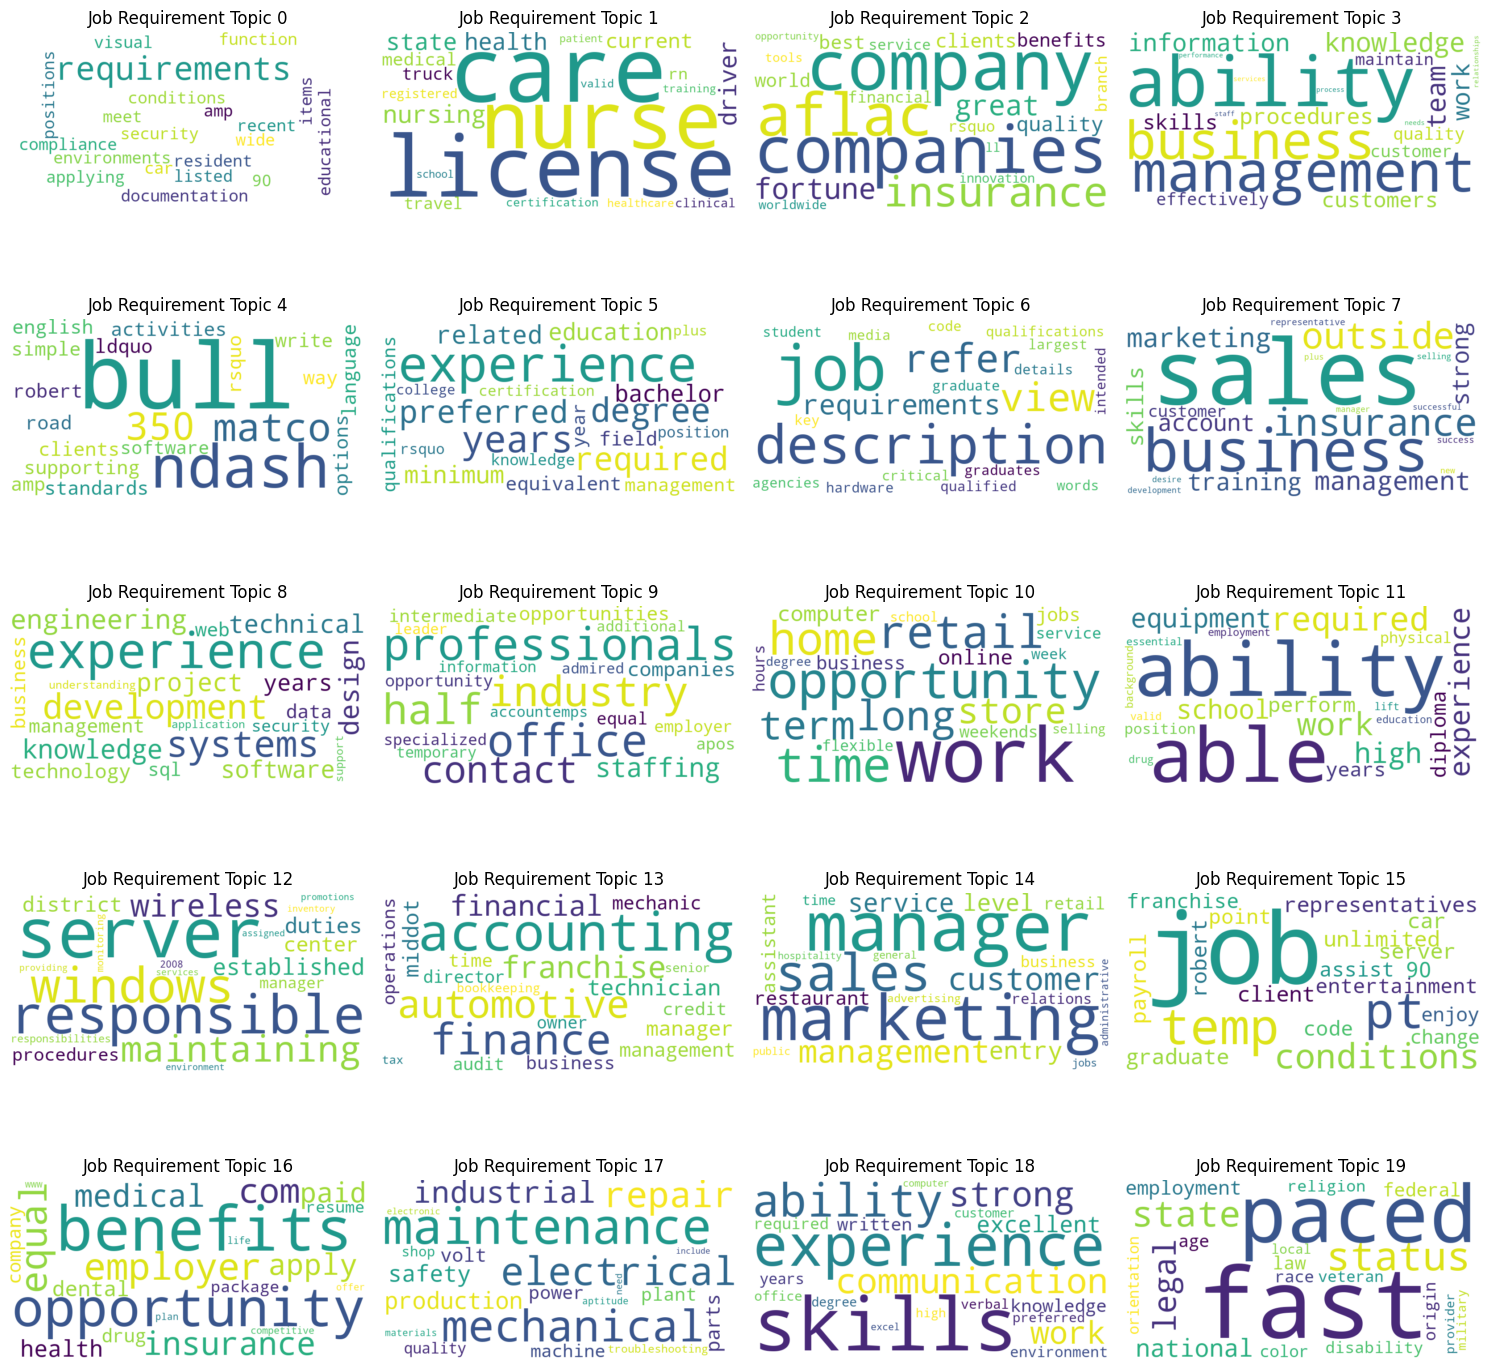

In [89]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics and top words to display
num_topics = lda_req.n_components
num_top_words = 20

# Create subplots for each topic
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15), sharex=True, sharey=True)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    print('topic index: ', topic_idx)
    # Sort the indices in descending order of word contributions
    sorted_indices = np.argsort(topic)[::-1]
    # Get the top words and their contributions
    top_words = [feature_names[i] for i in sorted_indices[:num_top_words]]
    word_contributions = [topic[i] for i in sorted_indices[:num_top_words]]

    # Create a dictionary of word contributions
    word_contributions_dict = dict(zip(top_words, word_contributions))

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=100).generate_from_frequencies(word_contributions_dict)

    # Plot the word cloud in the corresponding subplot
    row_idx = topic_idx // 4
    col_idx = topic_idx % 4
    axes[row_idx, col_idx].imshow(wordcloud, interpolation='bilinear')
    axes[row_idx, col_idx].set_title(f"Job Requirement Topic {topic_idx}")
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the individual subplot as a PNG file
plt.savefig("./nb_xai_viz/ReqTopic_wordcloud_approach2.png", bbox_inches='tight', dpi=300)
# Show the plot
plt.show()


topic index:  0
topic index:  1
topic index:  2
topic index:  3
topic index:  4
topic index:  5
topic index:  6
topic index:  7
topic index:  8
topic index:  9
topic index:  10
topic index:  11
topic index:  12
topic index:  13
topic index:  14
topic index:  15
topic index:  16
topic index:  17
topic index:  18
topic index:  19


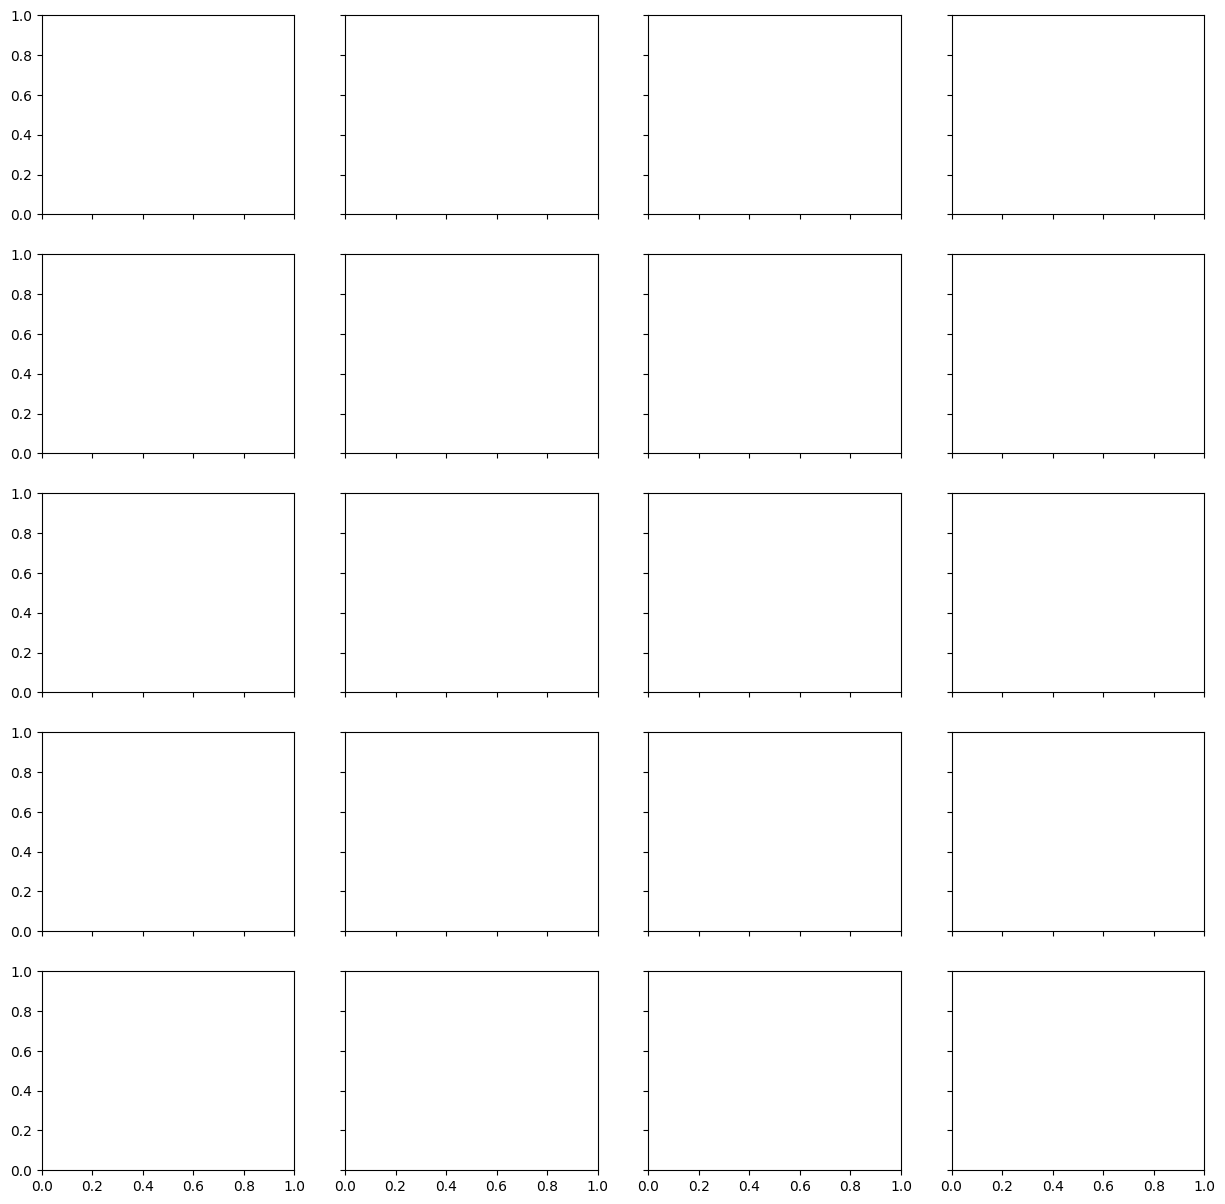

In [90]:
# CODE TO SAVE SUBPLOT in high-resolution
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics and top words to display
num_topics = lda_req.n_components
num_top_words = 20

# Create subplots for each topic
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15), sharex=True, sharey=True)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    print('topic index: ', topic_idx)
    # Sort the indices in descending order of word contributions
    sorted_indices = np.argsort(topic)[::-1]
    # Get the top words and their contributions
    top_words = [feature_names[i] for i in sorted_indices[:num_top_words]]
    word_contributions = [topic[i] for i in sorted_indices[:num_top_words]]

    # Create a dictionary of word contributions
    word_contributions_dict = dict(zip(top_words, word_contributions))

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=100).generate_from_frequencies(word_contributions_dict)

    # Plot the word cloud in a new figure
    plt.figure(figsize=(8, 4.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Job Requirement Topic {topic_idx}")
    plt.axis('off')

    # Save the individual subplot as a PNG file to the "wordclouds" directory
    save_dir = "output_lda_plot/approach2"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_path = os.path.join(save_dir, f"reqtopic_{topic_idx}.png")
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    plt.close()

## Corpus: Job Description

In [91]:
import numpy as np

# Get the word-topic distribution matrix
word_topic_matrix = lda_desc.components_

# Get the feature names from the vectorizer
feature_names = tf_feature_names_desc

# Normalize the word-topic distribution matrix
word_topic_matrix /= word_topic_matrix.sum(axis=1, keepdims=True)

# Set the number of topics and top words to display
num_topics = lda_desc.n_components
num_top_words = 20

# Print the top words for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Job Description topic {topic_idx}:")
    print(top_words)
    print()


Job Description topic 0:
['client', 'clients', 'staffing', 'candidates', 'firm', 'great', 'recruiting', 'offices', 'job', 'professional', 'permanent', 'seeking', 'located', 'providing', 'associates', 'candidate', 'kforce', 'hire', 'people', 'healthcare']

Job Description topic 1:
['procedures', 'ensure', 'policies', 'duties', 'appropriate', 'assigned', 'compliance', 'quality', 'staff', 'standards', 'activities', 'management', 'required', 'responsible', 'training', 'including', 'responsibilities', 'reports', 'issues', 'related']

Job Description topic 2:
['customer', 'customers', 'service', 'sales', 'products', 'services', 'product', 'needs', 'account', 'company', 'provide', 'new', 'maintain', 'accounts', 'calls', 'responsible', 'assigned', 'responsibilities', 'knowledge', 'providing']

Job Description topic 3:
['store', 'retail', 'sales', 'manager', 'customer', 'service', 'wireless', 'merchandise', 'management', 'associates', 'stores', 'inventory', 'assistant', 'merchandising', 'compan

topic index:  0
topic index:  1
topic index:  2
topic index:  3
topic index:  4
topic index:  5
topic index:  6
topic index:  7
topic index:  8
topic index:  9
topic index:  10
topic index:  11
topic index:  12
topic index:  13
topic index:  14
topic index:  15
topic index:  16
topic index:  17
topic index:  18
topic index:  19


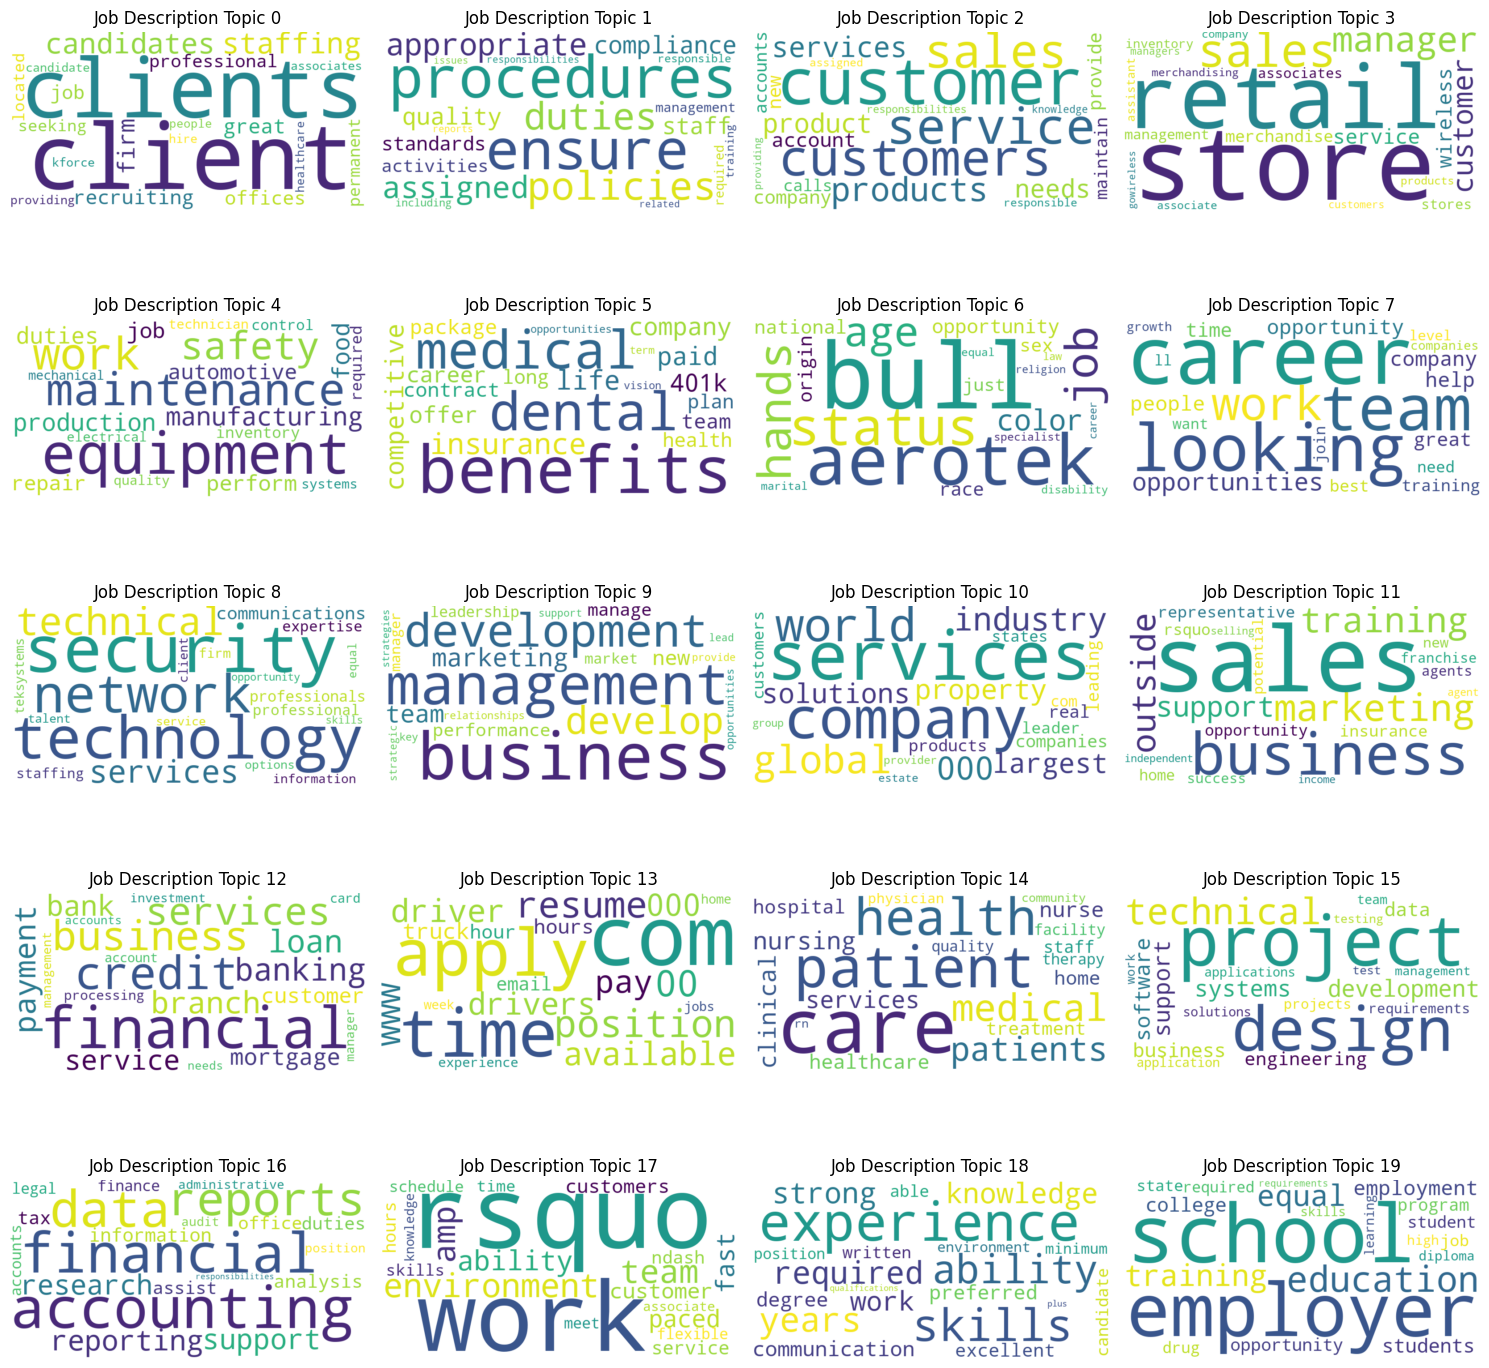

In [92]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics and top words to display
num_topics = lda_desc.n_components
num_top_words = 20

# Create subplots for each topic
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15), sharex=True, sharey=True)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    print('topic index: ', topic_idx)
    # Sort the indices in descending order of word contributions
    sorted_indices = np.argsort(topic)[::-1]
    # Get the top words and their contributions
    top_words = [feature_names[i] for i in sorted_indices[:num_top_words]]
    word_contributions = [topic[i] for i in sorted_indices[:num_top_words]]

    # Create a dictionary of word contributions
    word_contributions_dict = dict(zip(top_words, word_contributions))

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=100).generate_from_frequencies(word_contributions_dict)

    # Plot the word cloud in the corresponding subplot
    row_idx = topic_idx // 4
    col_idx = topic_idx % 4
    axes[row_idx, col_idx].imshow(wordcloud, interpolation='bilinear')
    axes[row_idx, col_idx].set_title(f"Job Description Topic {topic_idx}")
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the individual subplot as a PNG file
plt.savefig("./nb_xai_viz/DescTopic_wordcloud_approach2.png", bbox_inches='tight', dpi=300)
# Show the plot
plt.show()


topic index:  0
topic index:  1
topic index:  2
topic index:  3
topic index:  4
topic index:  5
topic index:  6
topic index:  7
topic index:  8
topic index:  9
topic index:  10
topic index:  11
topic index:  12
topic index:  13
topic index:  14
topic index:  15
topic index:  16
topic index:  17
topic index:  18
topic index:  19


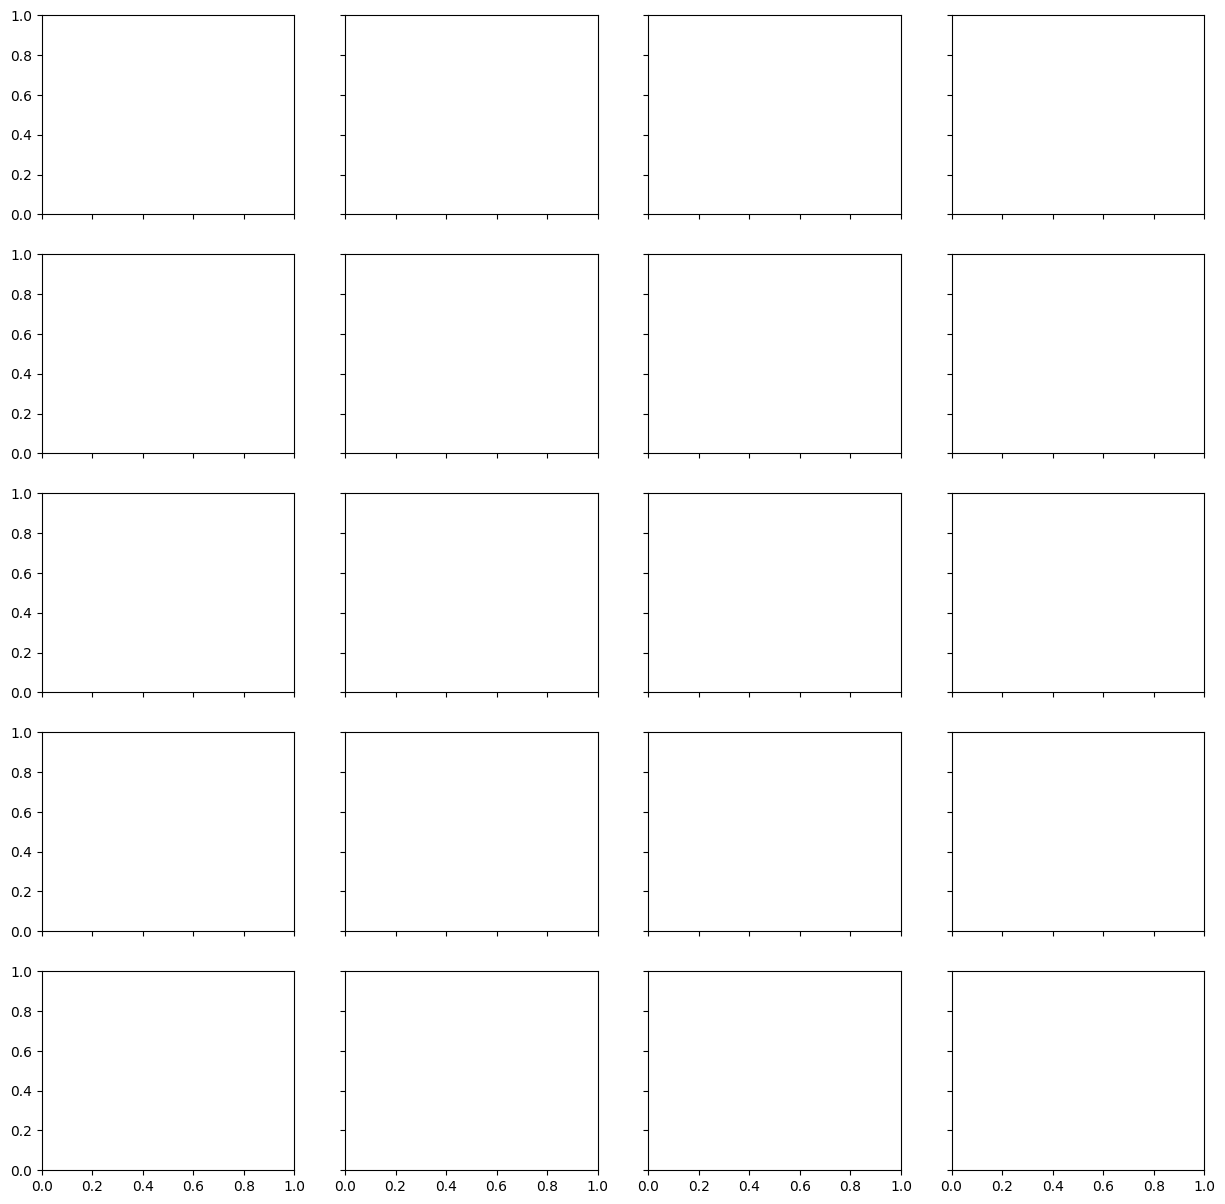

In [93]:
# CODE TO SAVE SUBPLOT in high-resolution
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics and top words to display
num_topics = lda_desc.n_components
num_top_words = 20

# Create subplots for each topic
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15), sharex=True, sharey=True)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    print('topic index: ', topic_idx)
    # Sort the indices in descending order of word contributions
    sorted_indices = np.argsort(topic)[::-1]
    # Get the top words and their contributions
    top_words = [feature_names[i] for i in sorted_indices[:num_top_words]]
    word_contributions = [topic[i] for i in sorted_indices[:num_top_words]]

    # Create a dictionary of word contributions
    word_contributions_dict = dict(zip(top_words, word_contributions))

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state = 100).generate_from_frequencies(word_contributions_dict)

    # Plot the word cloud in a new figure
    plt.figure(figsize=(8, 4.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Job Description Topic {topic_idx}")
    plt.axis('off')

    # Save the individual subplot as a PNG file to the "wordclouds" directory
    save_dir = "output_lda_plot/approach2"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_path = os.path.join(save_dir, f"desctopic_{topic_idx}.png")
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    plt.close()

## Corpus: Job Title

In [94]:
import numpy as np

# Get the word-topic distribution matrix
word_topic_matrix = lda_title.components_

# Get the feature names from the vectorizer
feature_names = tf_feature_names_title

# Normalize the word-topic distribution matrix
word_topic_matrix /= word_topic_matrix.sum(axis=1, keepdims=True)

# Set the number of topics and top words to display
num_topics = lda_title.n_components
num_top_words = 20

# Print the top words for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"Job Title topic {topic_idx}:")
    print(top_words)
    print()


Job Title topic 0:
['level', 'entry', 'restaurant', 'truck', 'needed', 'staff', 'data', 'accounting', 'new', 'prn', 'drivers', 'area', 'technology', 'diem', 'hiring', 'ny', 'president', 'north', 'line', 'reporting']

Job Title topic 1:
['time', 'associate', 'accountant', 'franchise', 'warehouse', 'certified', 'auditor', 'commercial', 'tax', 'property', 'labor', 'internal', 'audit', 'repair', 'principal', 'houston', 'local', 'handler', 'j2ee', 'material']

Job Title topic 2:
['support', 'openings', 'tech', 'operator', 'teller', 'controller', 'machine', 'machinist', 'owner', 'admin', 'surgical', 'plant', 'education', 'forklift', 'practice', 'pharmaceutical', 'order', 'specialty', 'special', 'cardiac']

Job Title topic 3:
['sales', 'representative', 'account', 'insurance', 'outside', 'office', 'wireless', 'inside', 'opportunities', 'mortgage', 'desk', 'territory', 'admissions', 'advertising', 'representatives', 'ma', 'market', 'national', 'wanted', 'reps']

Job Title topic 4:
['senior', '

topic index:  0
topic index:  1
topic index:  2
topic index:  3
topic index:  4
topic index:  5
topic index:  6
topic index:  7
topic index:  8
topic index:  9
topic index:  10
topic index:  11
topic index:  12
topic index:  13
topic index:  14
topic index:  15
topic index:  16
topic index:  17
topic index:  18
topic index:  19


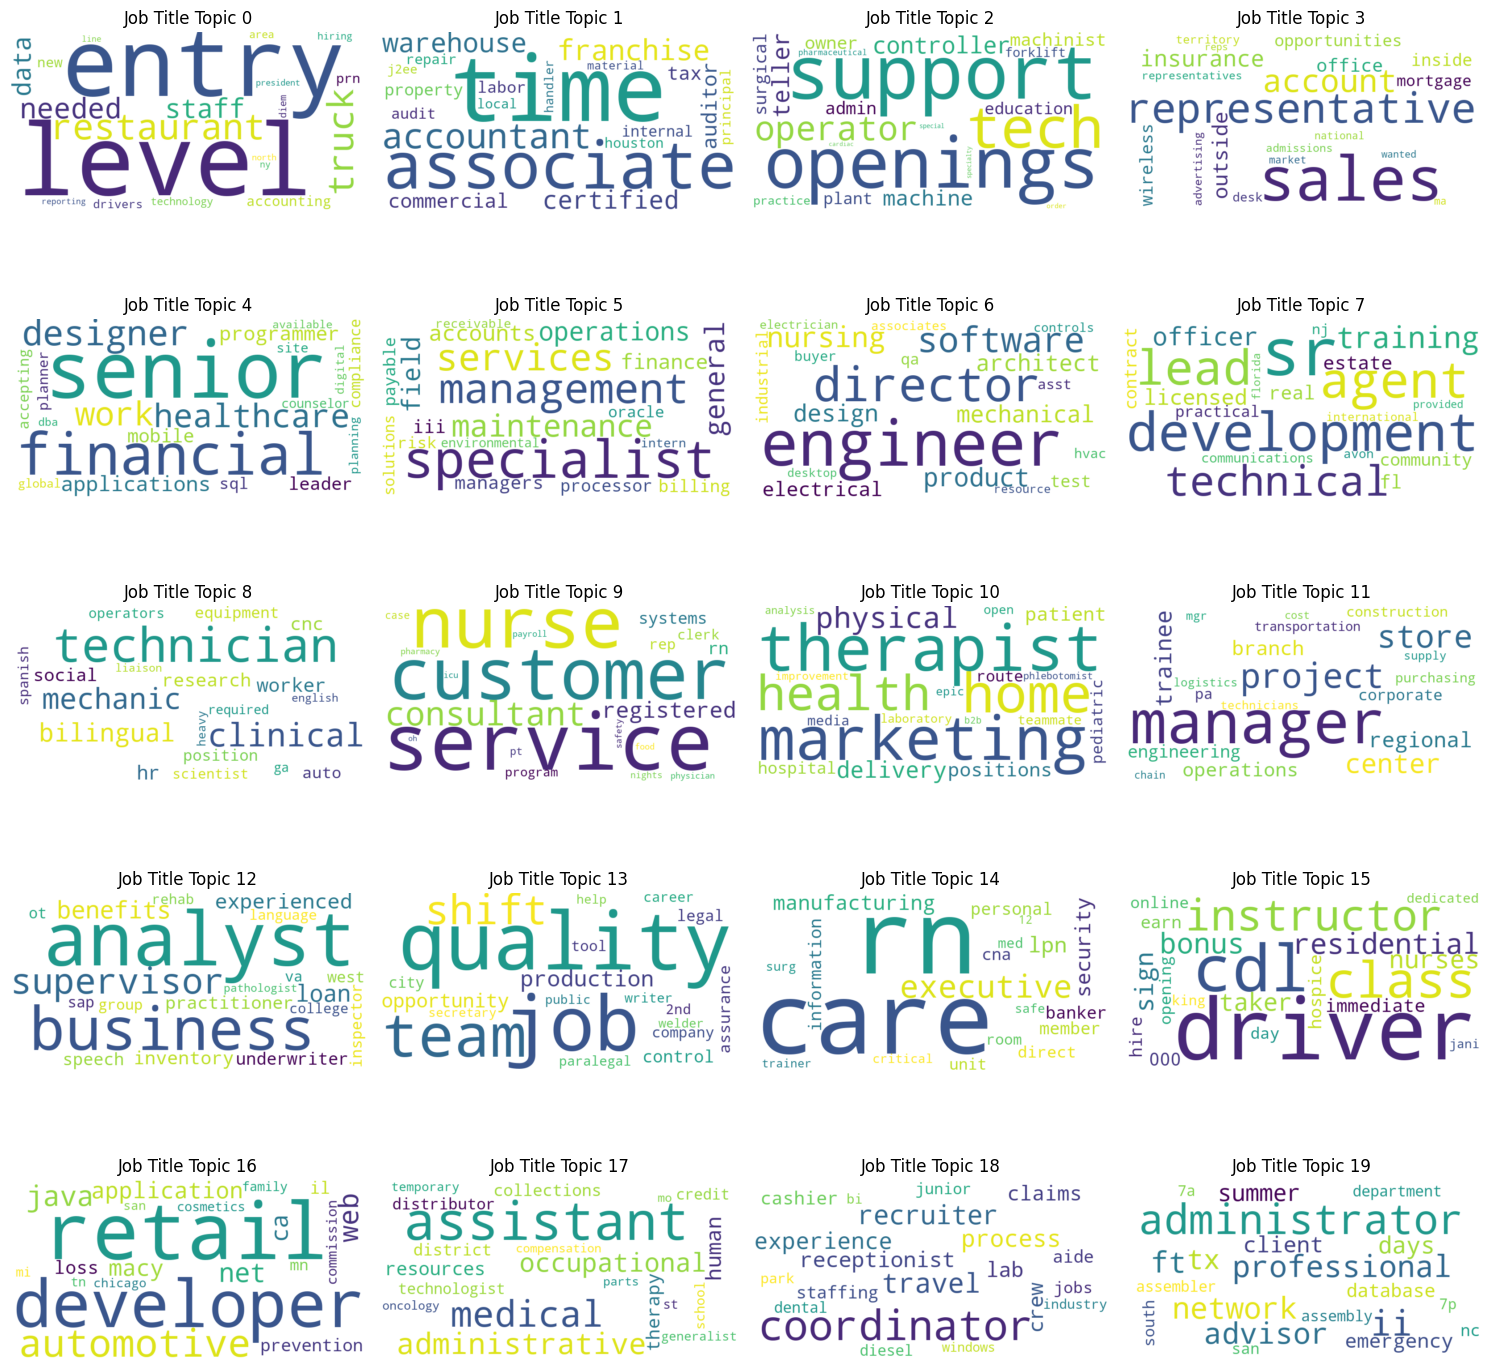

In [95]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics and top words to display
num_topics = lda_title.n_components
num_top_words = 20

# Create subplots for each topic
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15), sharex=True, sharey=True)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    print('topic index: ', topic_idx)
    # Sort the indices in descending order of word contributions
    sorted_indices = np.argsort(topic)[::-1]
    # Get the top words and their contributions
    top_words = [feature_names[i] for i in sorted_indices[:num_top_words]]
    word_contributions = [topic[i] for i in sorted_indices[:num_top_words]]

    # Create a dictionary of word contributions
    word_contributions_dict = dict(zip(top_words, word_contributions))

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=100).generate_from_frequencies(word_contributions_dict)

    # Plot the word cloud in the corresponding subplot
    row_idx = topic_idx // 4
    col_idx = topic_idx % 4
    axes[row_idx, col_idx].imshow(wordcloud, interpolation='bilinear')
    axes[row_idx, col_idx].set_title(f"Job Title Topic {topic_idx}")
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the individual subplot as a PNG file
plt.savefig("./nb_xai_viz/TitleTopic_wordcloud_approach2.png", bbox_inches='tight', dpi=300)
# Show the plot
plt.show()


topic index:  0
topic index:  1
topic index:  2
topic index:  3
topic index:  4
topic index:  5
topic index:  6
topic index:  7
topic index:  8
topic index:  9
topic index:  10
topic index:  11
topic index:  12
topic index:  13
topic index:  14
topic index:  15
topic index:  16
topic index:  17
topic index:  18
topic index:  19


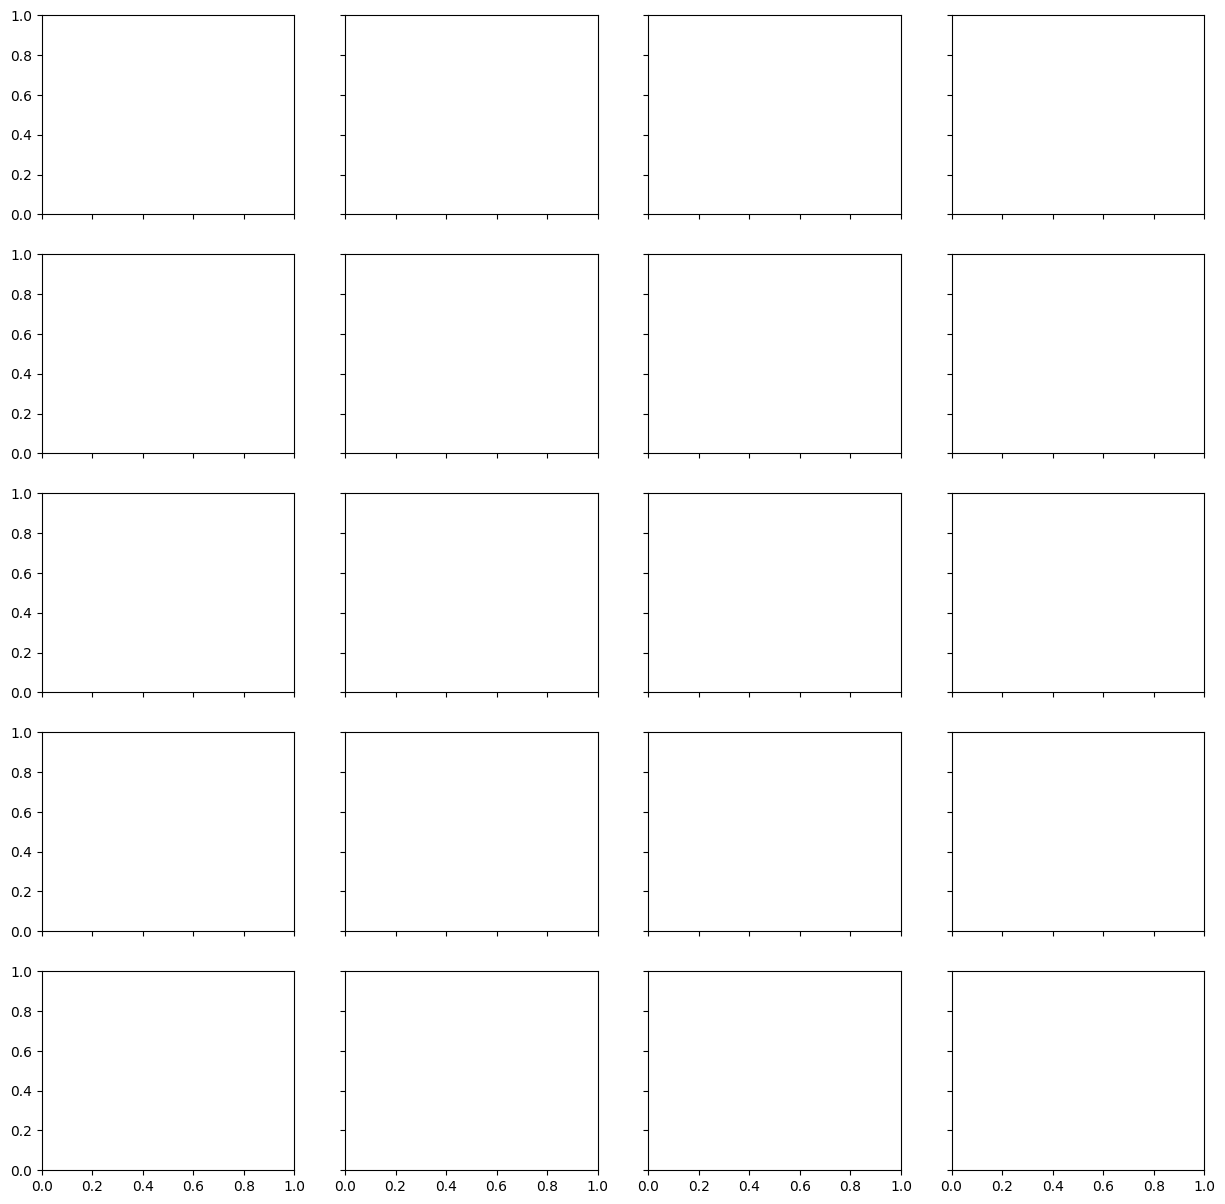

In [96]:
# CODE TO SAVE SUBPLOT in high-resolution
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics and top words to display
num_topics = lda_title.n_components
num_top_words = 20

# Create subplots for each topic
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15), sharex=True, sharey=True)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    print('topic index: ', topic_idx)
    # Sort the indices in descending order of word contributions
    sorted_indices = np.argsort(topic)[::-1]
    # Get the top words and their contributions
    top_words = [feature_names[i] for i in sorted_indices[:num_top_words]]
    word_contributions = [topic[i] for i in sorted_indices[:num_top_words]]

    # Create a dictionary of word contributions
    word_contributions_dict = dict(zip(top_words, word_contributions))

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=100).generate_from_frequencies(word_contributions_dict)

    # Plot the word cloud in a new figure
    plt.figure(figsize=(8, 4.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Job Title Topic {topic_idx}")
    plt.axis('off')

    # Save the individual subplot as a PNG file to the "wordclouds" directory
    save_dir = "output_lda_plot/approach2"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_path = os.path.join(save_dir, f"titletopic_{topic_idx}.png")
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    plt.close()

## Corpus: User Work History

In [97]:
import numpy as np

# Get the word-topic distribution matrix
word_topic_matrix = lda_user.components_

# Get the feature names from the vectorizer
feature_names = tf_feature_names_user

# Normalize the word-topic distribution matrix
word_topic_matrix /= word_topic_matrix.sum(axis=1, keepdims=True)

# Set the number of topics and top words to display
num_topics = lda_user.n_components
num_top_words = 20

# Print the top words for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
    print(f"WorkHistory topic {topic_idx}:")
    print(top_words)
    print()


WorkHistory topic 0:
['cashier', 'counselor', 'property', 'lab', 'retail', 'volunteer', 'floor', 'employee', 'planner', 'prevention', 'bartender', 'youth', 'loss', 'audit', 'camp', 'private', 'partner', 'projects', 'labor', 'deli']

WorkHistory topic 1:
['manager', 'senior', 'maintenance', 'owner', 'shift', 'aide', 'chief', 'client', 'legal', 'crew', 'independent', 'manageroffice', 'handler', 'stock', 'benefits', 'leasing', 'house', 'operation', 'paralegal', 'beverage']

WorkHistory topic 2:
['support', 'operations', 'technical', 'rep', 'member', 'network', 'engineering', 'charge', 'collections', 'new', 'programmer', 'ii', 'staffing', 'analystsenior', 'desktop', 'cash', 'collection', 'liaison', 'application', 'broker']

WorkHistory topic 3:
['sales', 'manager', 'resources', 'human', 'representative', 'claims', 'regional', 'advisor', 'representativesales', 'internship', 'material', 'group', 'area', 'mortgage', 'inside', 'managerregional', 'international', 'outside', 'territory', 'consul

topic index:  0
topic index:  1
topic index:  2
topic index:  3
topic index:  4
topic index:  5
topic index:  6
topic index:  7
topic index:  8
topic index:  9
topic index:  10
topic index:  11
topic index:  12
topic index:  13
topic index:  14
topic index:  15
topic index:  16
topic index:  17
topic index:  18
topic index:  19


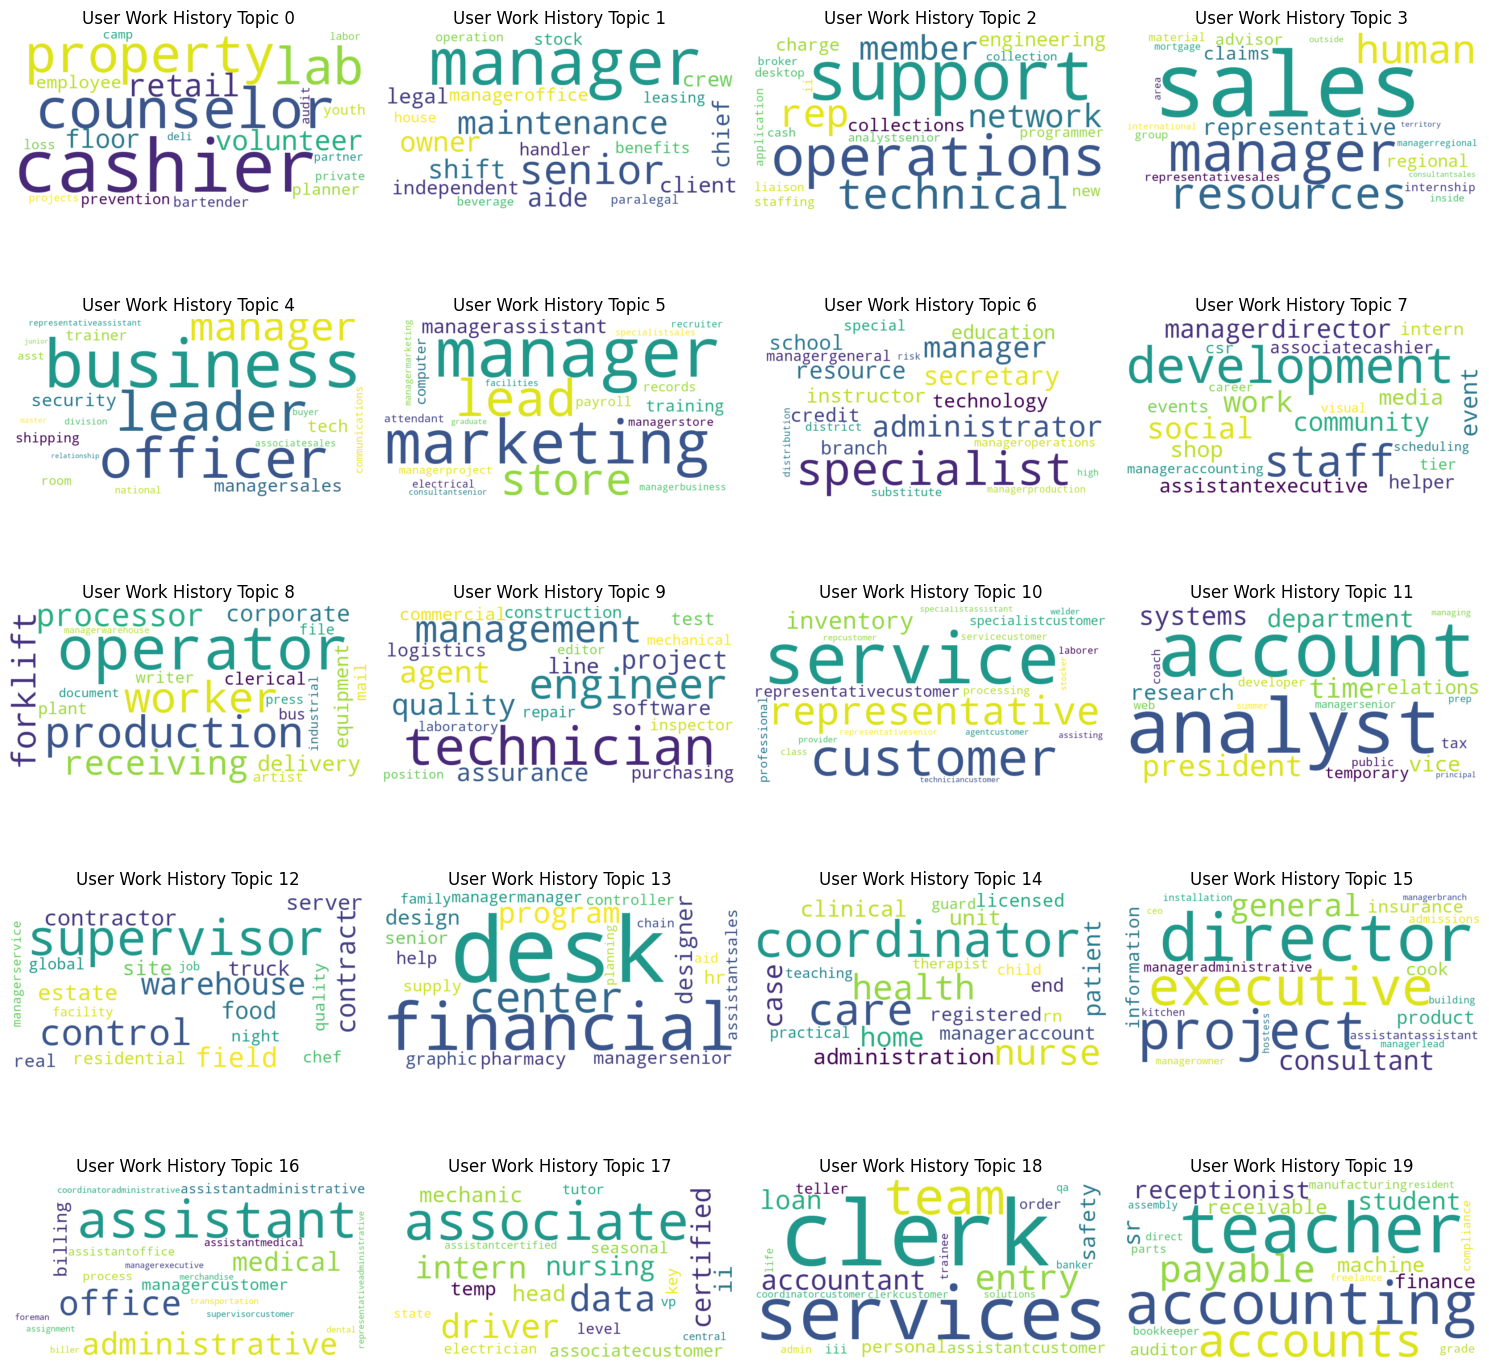

In [98]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics and top words to display
num_topics = lda_user.n_components
num_top_words = 20

# Create subplots for each topic
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15), sharex=True, sharey=True)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    print('topic index: ', topic_idx)
    # Sort the indices in descending order of word contributions
    sorted_indices = np.argsort(topic)[::-1]
    # Get the top words and their contributions
    top_words = [feature_names[i] for i in sorted_indices[:num_top_words]]
    word_contributions = [topic[i] for i in sorted_indices[:num_top_words]]

    # Create a dictionary of word contributions
    word_contributions_dict = dict(zip(top_words, word_contributions))

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=100).generate_from_frequencies(word_contributions_dict)

    # Plot the word cloud in the corresponding subplot
    row_idx = topic_idx // 4
    col_idx = topic_idx % 4
    axes[row_idx, col_idx].imshow(wordcloud, interpolation='bilinear')
    axes[row_idx, col_idx].set_title(f"User Work History Topic {topic_idx}")
    axes[row_idx, col_idx].axis('off')

# Adjust the spacing between subplots
plt.tight_layout()

# Save the individual subplot as a PNG file
plt.savefig("./nb_xai_viz/WorkHistoryTopic_wordcloud_approach2.png", bbox_inches='tight', dpi=300)
# Show the plot
plt.show()


topic index:  0
topic index:  1
topic index:  2
topic index:  3
topic index:  4
topic index:  5
topic index:  6
topic index:  7
topic index:  8
topic index:  9
topic index:  10
topic index:  11
topic index:  12
topic index:  13
topic index:  14
topic index:  15
topic index:  16
topic index:  17
topic index:  18
topic index:  19


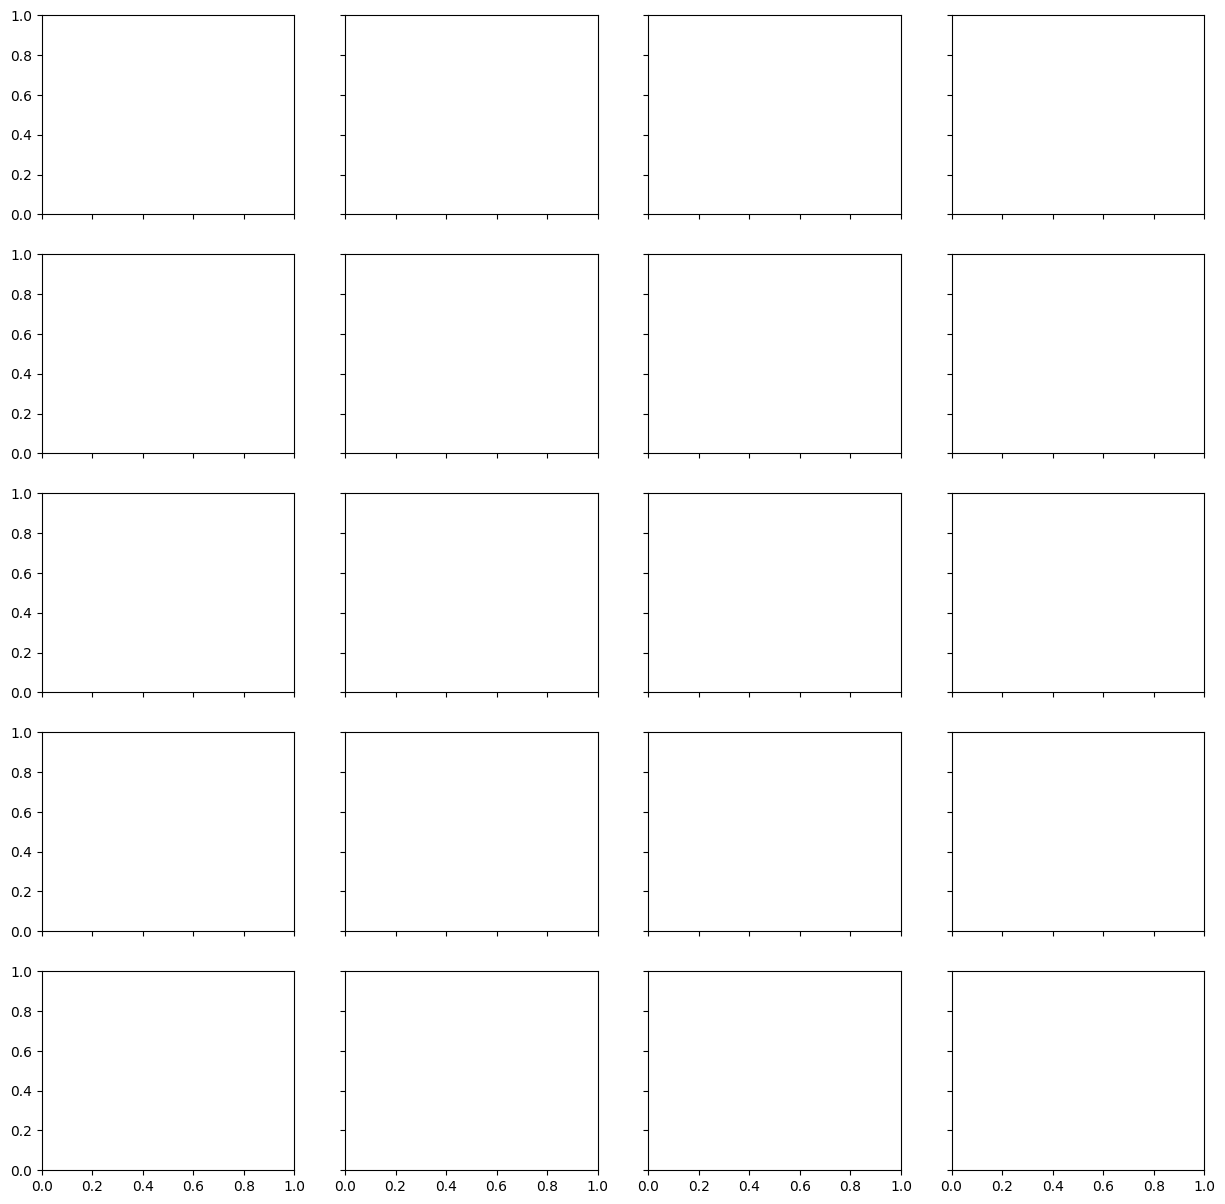

In [99]:
# CODE TO SAVE SUBPLOT in high-resolution
import os
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Set the number of topics and top words to display
num_topics = lda_user.n_components
num_top_words = 20

# Create subplots for each topic
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(15, 15), sharex=True, sharey=True)

# Generate word clouds for each topic
for topic_idx, topic in enumerate(word_topic_matrix):
    print('topic index: ', topic_idx)
    # Sort the indices in descending order of word contributions
    sorted_indices = np.argsort(topic)[::-1]
    # Get the top words and their contributions
    top_words = [feature_names[i] for i in sorted_indices[:num_top_words]]
    word_contributions = [topic[i] for i in sorted_indices[:num_top_words]]

    # Create a dictionary of word contributions
    word_contributions_dict = dict(zip(top_words, word_contributions))

    # Create a word cloud object
    wordcloud = WordCloud(width=800, height=400, background_color='white', random_state=100).generate_from_frequencies(word_contributions_dict)

    # Plot the word cloud in a new figure
    plt.figure(figsize=(8, 4.5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"User Work History {topic_idx}")
    plt.axis('off')

    # Save the individual subplot as a PNG file to the "wordclouds" directory
    save_dir = "output_lda_plot/approach2"
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    file_path = os.path.join(save_dir, f"work_history_topic_{topic_idx}.png")
    plt.savefig(file_path, bbox_inches='tight', dpi=300)
    plt.close()

# UDF: Extract key words contribute to a dominant topic
- Purpose: Show the word in the document (Job Requirement, Job Description, Job Title, or WorkHistory) that contribute the most to the given topic.
- Assumption: The words from the document that contribute most to a specific topic are the words in the document that have the highest probability under that topic.

In [101]:
def keywords_for_topic_in_doc(lda_model, dtm, feature_names, doc_idx, topic_idx, top_n=20):
    # Extract the topic-word distribution and document-topic distribution from the LDA model
    topic_word_distributions = lda_model.components_ / lda_model.components_.sum(axis=1)[:, np.newaxis]
    doc_topic_distributions = lda_model.transform(dtm)

    # Extract the words from the document
    doc_word_indices = dtm[doc_idx].indices
    doc_words = [feature_names[idx] for idx in doc_word_indices]

    # Calculate the word probabilities for the given topic
    word_probs = {word: topic_word_distributions[topic_idx, idx] for word, idx in zip(doc_words, doc_word_indices)}

    # Sort the words by their probabilities under the topic
    sorted_words = sorted(word_probs.items(), key=lambda x: x[1], reverse=True)

    # Get the top N words
    top_words = sorted_words[:top_n]

    return top_words


In [103]:
# Test on the first document of Job Description => DescTopic: 15
job_lda.iloc[0].T

JobID                                                           1
WindowID                                                        1
Title                            Security Engineer Technical Lead
Description     Security Clearance Required:  Top Secret Job N...
Requirements    SKILL SET Network Security tools: Webdefend We...
City                                                   Washington
State                                                          DC
Country                                                        US
Zip5                                                        20531
StartDate                                 2012-03-07 13:17:01.643
EndDate                                       2012-04-06 23:59:59
ReqTopic                                                        5
DescTopic                                                      15
TitTopic                                                        0
Name: 0, dtype: object

In [107]:
# Check the dominant topic calculated by Approach 2 >> 9
df_document_topic_desc[df_document_topic_desc.JobID==1].T

JobDesc0
Topic0              0.00
Topic1              0.18
Topic2              0.00
Topic3              0.00
Topic4              0.00
Topic5              0.00
Topic6              0.00
Topic7              0.00
Topic8              0.19
Topic9              0.22
Topic10             0.00
Topic11             0.00
Topic12             0.00
Topic13             0.16
Topic14             0.00
Topic15             0.20
Topic16             0.00
Topic17             0.05
Topic18             0.00
Topic19             0.00
dominant_topic      9.00
JobID               1.00

In [108]:
# Test on the first document of Job Description
# Dominant topic: 9, Document index: 0
keywords_for_topic_in_doc(lda_model = lda_desc, 
                          dtm = tf_desc, 
                          feature_names = tf_feature_names_desc, 
                          doc_idx = 0, 
                          topic_idx = 9, 
                          top_n=20)

[('business', 0.03587712330051927),
 ('management', 0.026885448285673394),
 ('development', 0.016329561354045546),
 ('team', 0.015098876116710114),
 ('support', 0.007384917898699977),
 ('opportunities', 0.007185202899721238),
 ('provide', 0.007093420594112907),
 ('including', 0.00606480483261909),
 ('operations', 0.0057492055413332025),
 ('developing', 0.005709677660806241),
 ('resources', 0.005675573508564411),
 ('ensure', 0.005431096159942172),
 ('strategy', 0.005185846319119955),
 ('initiatives', 0.004847806503718227),
 ('best', 0.004260707630184792),
 ('overall', 0.003214615467804556),
 ('day', 0.002668980312101794),
 ('division', 0.002275694671141752),
 ('provides', 0.0022181714851598104),
 ('include', 0.002202677622582243)]

In [109]:
# Test on the first document of Job Description
# Dominant topic: 15, Document index: 0
keywords_for_topic_in_doc(lda_model = lda_desc, 
                          dtm = tf_desc, 
                          feature_names = tf_feature_names_desc, 
                          doc_idx = 0, 
                          topic_idx = 15, 
                          top_n=20)

[('design', 0.026288841469838186),
 ('technical', 0.022253605939820505),
 ('development', 0.022196973479941495),
 ('support', 0.021745990564312343),
 ('business', 0.016273369990518805),
 ('team', 0.011229797909554171),
 ('management', 0.010130921292696257),
 ('provide', 0.006940234350921113),
 ('issues', 0.006134775257191542),
 ('including', 0.005475105647902998),
 ('integration', 0.004110336727712318),
 ('developing', 0.003666175298302083),
 ('architecture', 0.003601054693428481),
 ('include', 0.0034067172049736436),
 ('job', 0.0025748460527377807),
 ('practices', 0.0025729593496549245),
 ('ensure', 0.0022891078112348457),
 ('best', 0.0020776168946009714),
 ('customer', 0.0017422128314173008),
 ('provides', 0.0016665422484900673)]